<a href="https://colab.research.google.com/github/RainiBenaiah/Smart-beehive-prototype/blob/main/Capstone_Model_Aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  LIBRARY IMPORTS

# AsaliAsPossible - Beehive Monitoring & Decision System
# All required libraries for data processing, modeling, and visualization


import warnings
warnings.filterwarnings('ignore')

# === Core Data Manipulation ===
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import os
import sys
from datetime import datetime, timedelta
import json
import pickle

# === Data Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# === Audio Processing ===
import librosa
import librosa.display
import soundfile as sf
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, fftfreq

# === Machine Learning - Preprocessing ===
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# === Machine Learning - Classical Models ===
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC, SVR, OneClassSVM
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# === Machine Learning - Metrics ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)

# === Time Series Analysis ===
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# === Deep Learning (TensorFlow/Keras) ===
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, callbacks
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import (
        Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten,
        Dropout, BatchNormalization, Activation, Input,
        Concatenate, Attention, MultiHeadAttention
    )
    print(f" TensorFlow version: {tf.__version__}")
except ImportError:
    print(" TensorFlow not available - deep learning models will be skipped")

# === Utilities ===
from collections import Counter, defaultdict
from itertools import combinations
import glob
from tqdm.auto import tqdm
tqdm.pandas()

# === Configuration ===
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("=" * 80)
print("✓ ALL LIBRARIES IMPORTED SUCCESSFULLY")
print("=" * 80)
print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Librosa version: {librosa.__version__}")
print("=" * 80)

 TensorFlow version: 2.19.0
✓ ALL LIBRARIES IMPORTED SUCCESSFULLY
Python version: 3.12.11
Pandas version: 2.2.2
NumPy version: 2.0.2
Scikit-learn version: 1.6.1
Librosa version: 0.11.0


In [2]:
# CELL 2: SETUP PATHS & ENVIRONMENT

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print(" Google Drive mounted")
except:
    print(" Not running in Colab or Drive already mounted")

# Define paths
BASE_PATH = Path('/content/drive/MyDrive/AsaliAsPossible')
WORK_DIR = Path('/content/asali_work')
WORK_DIR.mkdir(exist_ok=True)

# Create subdirectories for organized workflow
PROCESSED_DATA_DIR = WORK_DIR / 'processed_data'
MODELS_DIR = WORK_DIR / 'models'
FIGURES_DIR = WORK_DIR / 'figures'
AUDIO_FEATURES_DIR = WORK_DIR / 'audio_features'
LOGS_DIR = WORK_DIR / 'logs'

for directory in [PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, AUDIO_FEATURES_DIR, LOGS_DIR]:
    directory.mkdir(exist_ok=True)

print("=" * 80)
print(" SETUP COMPLETE!")
print("=" * 80)
print(f" Your data source: {BASE_PATH}")
print(f" Working directory: {WORK_DIR}")
print(f" Processed data:   {PROCESSED_DATA_DIR}")
print(f" Models:           {MODELS_DIR}")
print(f" Figures:          {FIGURES_DIR}")
print(f" Audio features:   {AUDIO_FEATURES_DIR}")
print(f" Logs:             {LOGS_DIR}")
print("=" * 80)

# Verify BASE_PATH exists
if not BASE_PATH.exists():
    print(f" ERROR: {BASE_PATH} does not exist!")
    print("Please check your Google Drive path.")
else:
    print(f" Data directory verified: {BASE_PATH.exists()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive mounted
 SETUP COMPLETE!
 Your data source: /content/drive/MyDrive/AsaliAsPossible
 Working directory: /content/asali_work
 Processed data:   /content/asali_work/processed_data
 Models:           /content/asali_work/models
 Figures:          /content/asali_work/figures
 Audio features:   /content/asali_work/audio_features
 Logs:             /content/asali_work/logs
 Data directory verified: True


In [3]:
#  LIST & UNZIP FILES


print("=" * 80)
print(" SCANNING DATASETS")
print("=" * 80)

# List all files in BASE_PATH
all_files = list(BASE_PATH.glob('*'))
zip_files = [f for f in all_files if f.suffix == '.zip']
other_files = [f for f in all_files if f.suffix != '.zip']

# Display ZIP files
print(f"\n Found {len(zip_files)} ZIP files:")
for f in zip_files:
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"   {''} {f.name:<40} ({size_mb:>8.2f} MB)")

# Display other files
print(f"\n Found {len(other_files)} other files:")
display_limit = 15
for f in other_files[:display_limit]:
    size_mb = f.stat().st_size / (1024 * 1024)
    icon = '🎵' if f.suffix in ['.wav', '.mp3', '.flac'] else ''
    print(f"   {icon} {f.name:<40} ({size_mb:>8.2f} MB)")
if len(other_files) > display_limit:
    print(f"   ... and {len(other_files) - display_limit} more files")

# Unzip all ZIP files to working directory
print("\n" + "=" * 80)
print(" EXTRACTING ZIP FILES")
print("=" * 80)

extraction_log = []
for zip_file in zip_files:
    try:
        print(f"Extracting: {zip_file.name}...", end=' ')
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            # Extract to working directory
            zip_ref.extractall(WORK_DIR)
            num_files = len(zip_ref.namelist())
            print(f" ({num_files} files)")
            extraction_log.append({
                'file': zip_file.name,
                'status': 'success',
                'files_extracted': num_files
            })
    except Exception as e:
        print(f" ERROR: {str(e)}")
        extraction_log.append({
            'file': zip_file.name,
            'status': 'failed',
            'error': str(e)
        })

print(f"\n Extraction complete! Files extracted to: {WORK_DIR}")

 SCANNING DATASETS

 Found 6 ZIP files:
    temperature_2017.csv.zip                 (    2.24 MB)
    weight_2017.csv.zip                      (    1.60 MB)
    nuhive_processed.zip                     ( 2576.58 MB)
    sol.zip                                  ( 8076.94 MB)
    sound_files.zip                          (19718.02 MB)
    flow_2017.csv.zip                        (    2.74 MB)

 Found 5 other files:
    Hive17.csv                               (    0.10 MB)
    humidity_2017.csv                        (    0.31 MB)
    all_data_updated.csv                     (    0.16 MB)
    CF001 - Missing Queen - Day - (1).lab    (    0.00 MB)
    .ipynb_checkpoints                       (    0.00 MB)

 EXTRACTING ZIP FILES
Extracting: temperature_2017.csv.zip...  (1 files)
Extracting: weight_2017.csv.zip...  (1 files)
Extracting: nuhive_processed.zip...  (13792 files)
Extracting: sol.zip...  (5949 files)
Extracting: sound_files.zip...  (7100 files)
Extracting: flow_2017.csv.zip...  (

In [4]:
#  CATEGORIZE EXTRACTED FILES


print("=" * 80)
print(" DATA INVENTORY")
print("=" * 80)

# Scan all extracted files recursively
all_extracted = list(WORK_DIR.glob('**/*'))
all_extracted = [f for f in all_extracted if f.is_file()]  # Only files, not directories

# Categorize by file type
csv_files = [f for f in all_extracted if f.suffix == '.csv']
audio_files = [f for f in all_extracted if f.suffix in ['.wav', '.mp3', '.flac', '.ogg']]
label_files = [f for f in all_extracted if f.suffix == '.lab']
other_files = [f for f in all_extracted if f not in csv_files + audio_files + label_files]

# Summary statistics
print(f"\n SUMMARY:")
print(f"   Total files extracted: {len(all_extracted)}")
print(f"    CSV files:          {len(csv_files)}")
print(f"    Audio files:        {len(audio_files)}")
print(f"     Label files:        {len(label_files)}")
print(f"    Other files:        {len(other_files)}")

# Display sample CSV files
if csv_files:
    print(f"\n CSV FILES ({len(csv_files)} total):")
    for i, f in enumerate(csv_files[:10], 1):
        size_mb = f.stat().st_size / (1024 * 1024)
        rel_path = f.relative_to(WORK_DIR)
        print(f"   {i:2d}. {str(rel_path):<50} ({size_mb:>8.2f} MB)")
    if len(csv_files) > 10:
        print(f"       ... and {len(csv_files) - 10} more CSV files")

# Display sample audio files
if audio_files:
    print(f"\n AUDIO FILES ({len(audio_files)} total):")
    for i, f in enumerate(audio_files[:10], 1):
        size_kb = f.stat().st_size / 1024
        rel_path = f.relative_to(WORK_DIR)
        print(f"   {i:2d}. {str(rel_path):<50} ({size_kb:>8.1f} KB)")
    if len(audio_files) > 10:
        print(f"       ... and {len(audio_files) - 10} more audio files")

# Display sample label files
if label_files:
    print(f"\n  LABEL FILES ({len(label_files)} total):")
    for i, f in enumerate(label_files[:10], 1):
        size_kb = f.stat().st_size / 1024
        rel_path = f.relative_to(WORK_DIR)
        print(f"   {i:2d}. {str(rel_path):<50} ({size_kb:>8.1f} KB)")
    if len(label_files) > 10:
        print(f"       ... and {len(label_files) - 10} more label files")

# Copy non-zip files from BASE_PATH to WORK_DIR for consolidated access
print("\n" + "=" * 80)
print(" COPYING NON-ZIP FILES FROM SOURCE")
print("=" * 80)

import shutil
for f in other_files:
    source = BASE_PATH / f.name
    if source.exists():
        dest = WORK_DIR / f.name
        if not dest.exists():
            shutil.copy2(source, dest)
            print(f"    Copied: {f.name}")

print("\n All datasets are now in working directory!")
print("=" * 80)

# Store file paths for easy access later
FILE_INVENTORY = {
    'csv_files': csv_files,
    'audio_files': audio_files,
    'label_files': label_files,
    'all_files': all_extracted
}

# Save inventory
with open(WORK_DIR / 'file_inventory.json', 'w') as f:
    json.dump({
        'csv_files': [str(f) for f in csv_files],
        'audio_files': [str(f) for f in audio_files],
        'label_files': [str(f) for f in label_files],
    }, f, indent=2)

print(f" File inventory saved to: {WORK_DIR / 'file_inventory.json'}")

 DATA INVENTORY

 SUMMARY:
   Total files extracted: 26844
    CSV files:          4
    Audio files:        26840
     Label files:        0
    Other files:        0

 CSV FILES (4 total):
    1. train.csv                                          (    0.08 MB)
    2. temperature_2017.csv                               (   12.31 MB)
    3. weight_2017.csv                                    (   14.55 MB)
    4. flow_2017.csv                                      (   22.57 MB)

 AUDIO FILES (26840 total):
    1. 2022-06-25--02-48-45_2__segment4.wav               (  1249.0 KB)
    2. 2022-07-12--19-08-31_2__segment4.wav               (  1249.0 KB)
    3. 2022-07-10--08-42-00_1__segment4.wav               (  1249.0 KB)
    4. 2022-06-25--01-49-33_2__segment4.wav               (  1249.0 KB)
    5. 2022-07-02--07-58-20_1__segment5.wav               (  1249.0 KB)
    6. 2022-07-06--08-17-56_1__segment5.wav               (  1249.0 KB)
    7. 2022-06-10--12-36-08_1__segment0.wav               ( 

In [5]:
import tensorflow as tf

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):   # Force GPU usage
    x = tf.random.normal([3, 3])
    y = tf.square(x)

Num GPUs Available: 1


In [6]:
# DEscriptive CSV ANALYSIS - LOAD & PROFILE DATASETS

print("=" * 80)
print(" DETAILED CSV ANALYSIS")
print("=" * 80)

# Dictionary to store loaded dataframes
dataframes = {}
dataset_profiles = {}

# Get all CSV files
all_csv_files = list(WORK_DIR.glob('**/*.csv'))

print(f"\nAnalyzing {len(all_csv_files)} CSV files...\n")

for csv_file in all_csv_files:
    print(f"\n{'='*80}")
    print(f" ANALYZING: {csv_file.name}")
    print(f"{'='*80}")

    try:
        # Read the CSV
        df = pd.read_csv(csv_file, low_memory=False)
        dataset_name = csv_file.stem  # filename without extension

        print(f" Loaded successfully")
        print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Basic info
        print(f"\n COLUMN INFORMATION:")
        print(f"   {'Column Name':<30} {'Type':<15} {'Non-Null':<15} {'Null %':<10}")
        print(f"   {'-'*70}")

        for col in df.columns:
            non_null = df[col].notna().sum()
            null_pct = (df[col].isna().sum() / len(df)) * 100
            dtype = str(df[col].dtype)
            print(f"   {col:<30} {dtype:<15} {non_null:<15,} {null_pct:>6.2f}%")

        # Missing data summary
        total_missing = df.isna().sum().sum()
        missing_pct = (total_missing / (df.shape[0] * df.shape[1])) * 100
        print(f"\n MISSING DATA:")
        print(f"   Total missing values: {total_missing:,} ({missing_pct:.2f}%)")

        # Identify potential datetime columns
        print(f"\n DATETIME DETECTION:")
        datetime_cols = []
        for col in df.columns:
            # Check if column name suggests datetime
            if any(keyword in col.lower() for keyword in ['date', 'time', 'timestamp', 'datetime']):
                try:
                    # Try to parse as datetime
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                    if df[col].notna().sum() > 0:
                        datetime_cols.append(col)
                        print(f"  {col} → Converted to datetime")
                        print(f"      Range: {df[col].min()} to {df[col].max()}")
                except:
                    print(f"  {col} → Could not convert to datetime")

        if not datetime_cols:
            print(f"  No datetime columns detected")

        # Numeric columns summary
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        print(f"\n NUMERIC COLUMNS: {len(numeric_cols)}")

        if numeric_cols:
            print(f"\n   {'Column':<30} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
            print(f"   {'-'*80}")
            for col in numeric_cols[:10]:  # Show first 10
                if df[col].notna().sum() > 0:
                    print(f"   {col:<30} {df[col].min():<12.3f} {df[col].max():<12.3f} "
                          f"{df[col].mean():<12.3f} {df[col].std():<12.3f}")
            if len(numeric_cols) > 10:
                print(f"   ... and {len(numeric_cols) - 10} more numeric columns")

        # Categorical columns summary
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        # Remove datetime columns from categorical
        categorical_cols = [col for col in categorical_cols if col not in datetime_cols]

        print(f"\n CATEGORICAL COLUMNS: {len(categorical_cols)}")
        if categorical_cols:
            for col in categorical_cols[:5]:  # Show first 5
                unique_count = df[col].nunique()
                print(f"   {col}: {unique_count} unique values")
                if unique_count <= 10:
                    print(f"      Values: {df[col].value_counts().head().to_dict()}")
            if len(categorical_cols) > 5:
                print(f"   ... and {len(categorical_cols) - 5} more categorical columns")

        # Data sample
        print(f"\n FIRST 3 ROWS:")
        print(df.head(3).to_string())

        # Store dataframe and profile
        dataframes[dataset_name] = df
        dataset_profiles[dataset_name] = {
            'shape': df.shape,
            'columns': list(df.columns),
            'dtypes': df.dtypes.to_dict(),
            'datetime_cols': datetime_cols,
            'numeric_cols': numeric_cols,
            'categorical_cols': categorical_cols,
            'missing_pct': missing_pct,
            'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'file_path': str(csv_file)
        }

        print(f"\n Analysis complete for {dataset_name}")

    except Exception as e:
        print(f" ERROR: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*80}")
print(f" LOADED {len(dataframes)} DATASETS")
print(f"{'='*80}")

# Summary table
summary_data = []
for name, profile in dataset_profiles.items():
    summary_data.append({
        'Dataset': name,
        'Rows': profile['shape'][0],
        'Columns': profile['shape'][1],
        'Has DateTime': 'Yes' if profile['datetime_cols'] else 'No',
        'Missing %': f"{profile['missing_pct']:.2f}%",
        'Size (MB)': f"{profile['memory_mb']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n DATASET SUMMARY:")
print(summary_df.to_string(index=False))

# Save profiles
with open(PROCESSED_DATA_DIR / 'dataset_profiles.json', 'w') as f:
    json.dump(dataset_profiles, f, indent=2, default=str)

print(f"\n Dataset profiles saved to: {PROCESSED_DATA_DIR / 'dataset_profiles.json'}")

 DETAILED CSV ANALYSIS

Analyzing 4 CSV files...


 ANALYZING: train.csv
 Loaded successfully
   Shape: 1,275 rows × 2 columns
   Memory: 0.20 MB

 COLUMN INFORMATION:
   Column Name                    Type            Non-Null        Null %    
   ----------------------------------------------------------------------
   file name                      object          1,275             0.00%
   queen status                   object          1,275             0.00%

 MISSING DATA:
   Total missing values: 0 (0.00%)

 DATETIME DETECTION:
  No datetime columns detected

 NUMERIC COLUMNS: 0

 CATEGORICAL COLUMNS: 2
   file name: 1275 unique values
   queen status: 4 unique values
      Values: {'queen present and newly accepted': 679, 'queen present and rejected': 259, 'queen present or original queen': 179, 'queen not present': 158}

 FIRST 3 ROWS:
                              file name                     queen status
0  2022-06-08--14-52-28_1__segment0.wav  queen present or original quee

In [7]:
#  CATEGORIZE DATASETS BY PURPOSE (UPDATED)



print(" DATASET CATEGORIZATION")


# Manual categorization based on analysis
dataset_categories = {
    'sensor_timeseries': ['temperature_2017', 'weight_2017', 'flow_2017'],
    'audio_labels': ['train'],
    'audio_files': [],  # Will be populated when we inspect audio files
    'label_files': [],  # Will be populated when we inspect .lab files
}

print("\n IDENTIFIED DATASETS:\n")

# Sensor Time-Series
print("  SENSOR TIME-SERIES (3 datasets):")
print("    temperature_2017: Temperature readings (401,869 records)")
print("    weight_2017: Hive weight data (524,110 records)")
print("    flow_2017: Nectar flow measurements (1,048,220 records)")
print("    All have timestamps covering entire year 2017")
print("    No missing data")
print()

# Audio Labels
print(" AUDIO LABELS (1 dataset):")
print("    train: Queen status classification")
print("     - 1,275 audio files with labels")
print("     - 4 classes:")
print("       1. queen present or original queen (179 samples, 14.0%)")
print("       2. queen present and newly accepted (679 samples, 53.3%)")
print("       3. queen present and rejected (259 samples, 20.3%)")
print("       4. queen not present (158 samples, 12.4%)")
print("     Moderate class imbalance (largest:smallest = 4.3:1)")
print()

# Check for audio files
audio_files = FILE_INVENTORY['audio_files']
print(f" AUDIO FILES: {len(audio_files)} files found")
if len(audio_files) > 0:
    # Group by extension
    audio_by_ext = {}
    for f in audio_files:
        ext = f.suffix.lower()
        audio_by_ext[ext] = audio_by_ext.get(ext, 0) + 1

    for ext, count in audio_by_ext.items():
        print(f"   • {ext}: {count} files")

    # Sample paths
    print(f"\n   Sample files:")
    for f in audio_files[:3]:
        print(f"   - {f.relative_to(WORK_DIR)}")
else:
    print("  No audio files found yet - may need to extract from additional archives")
print()

# Check for label files
label_files = FILE_INVENTORY['label_files']
print(f"LABEL FILES (.lab): {len(label_files)} files found")
if len(label_files) > 0:
    print(f"   Sample files:")
    for f in label_files[:5]:
        print(f"   - {f.name}")
else:
    print("  No .lab files found in extracted archives")
print()


print(" Categorization complete")

 DATASET CATEGORIZATION

 IDENTIFIED DATASETS:

  SENSOR TIME-SERIES (3 datasets):
    temperature_2017: Temperature readings (401,869 records)
    weight_2017: Hive weight data (524,110 records)
    flow_2017: Nectar flow measurements (1,048,220 records)
    All have timestamps covering entire year 2017
    No missing data

 AUDIO LABELS (1 dataset):
    train: Queen status classification
     - 1,275 audio files with labels
     - 4 classes:
       1. queen present or original queen (179 samples, 14.0%)
       2. queen present and newly accepted (679 samples, 53.3%)
       3. queen present and rejected (259 samples, 20.3%)
       4. queen not present (158 samples, 12.4%)
     Moderate class imbalance (largest:smallest = 4.3:1)

 AUDIO FILES: 26840 files found
   • .wav: 26840 files

   Sample files:
   - 2022-06-25--02-48-45_2__segment4.wav
   - 2022-07-12--19-08-31_2__segment4.wav
   - 2022-07-10--08-42-00_1__segment4.wav

LABEL FILES (.lab): 0 files found
  No .lab files found in e

In [8]:

#  INSPECTION OF ALL CSV FILES



print(" COMPREHENSIVE CSV FILE CHECK")


# List ALL CSV files in working directory and subdirectories
all_csv_paths = list(WORK_DIR.glob('**/*.csv'))

print(f"\n Found {len(all_csv_paths)} CSV files in total:\n")

for csv_path in all_csv_paths:
    print(f"    {csv_path.relative_to(WORK_DIR)}")

# Check which ones we already loaded
loaded_datasets = list(dataframes.keys())
print(f"\n Already loaded: {len(loaded_datasets)} datasets")
for ds in loaded_datasets:
    print(f"    {ds}")

# Find unloaded CSV files
unloaded_csvs = []
for csv_path in all_csv_paths:
    stem = csv_path.stem
    if stem not in loaded_datasets:
        unloaded_csvs.append(csv_path)

if unloaded_csvs:
    print(f"\n  UNLOADED CSV FILES: {len(unloaded_csvs)} found")
    for csv_path in unloaded_csvs:
        print(f"    {csv_path.name}")

    # Load and analyze them
    print(f"\n{'='*80}")
    print(" LOADING UNLOADED CSV FILES")
    print(f"{'='*80}")

    for csv_path in unloaded_csvs:
        dataset_name = csv_path.stem

        print(f"\n{'='*80}")
        print(f" ANALYZING: {csv_path.name}")
        print(f"{'='*80}")

        try:
            # Read CSV
            df = pd.read_csv(csv_path, low_memory=False)

            print(f" Loaded successfully")
            print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
            print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

            # Column info
            print(f"\n COLUMNS ({len(df.columns)}):")
            print(f"   {'Column Name':<35} {'Type':<15} {'Non-Null':<15} {'Null %':<10} {'Unique':<10}")
            print(f"   {'-'*90}")

            for col in df.columns:
                non_null = df[col].notna().sum()
                null_pct = (df[col].isna().sum() / len(df)) * 100
                dtype = str(df[col].dtype)
                unique = df[col].nunique()
                print(f"   {col:<35} {dtype:<15} {non_null:<15,} {null_pct:>6.2f}% {unique:>8,}")

            # Missing data summary
            total_missing = df.isna().sum().sum()
            missing_pct = (total_missing / (df.shape[0] * df.shape[1])) * 100
            print(f"\n MISSING DATA:")
            print(f"   Total missing: {total_missing:,} ({missing_pct:.2f}%)")

            # Identify datetime columns
            print(f"\n DATETIME DETECTION:")
            datetime_cols = []
            for col in df.columns:
                if any(keyword in col.lower() for keyword in ['date', 'time', 'timestamp']):
                    try:
                        test_series = pd.to_datetime(df[col], errors='coerce')
                        valid_dates = test_series.notna().sum()
                        if valid_dates > len(df) * 0.5:  # At least 50% valid dates
                            df[col] = test_series
                            datetime_cols.append(col)
                            print(f"    {col} → Converted to datetime")
                            print(f"      Valid dates: {valid_dates:,} / {len(df):,} ({valid_dates/len(df)*100:.1f}%)")
                            if valid_dates > 0:
                                print(f"      Range: {df[col].min()} to {df[col].max()}")
                    except:
                        pass

            if not datetime_cols:
                print(f" No datetime columns detected")

            # Numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            print(f"\n NUMERIC COLUMNS: {len(numeric_cols)}")

            if numeric_cols and len(numeric_cols) > 0:
                print(f"\n   {'Column':<35} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
                print(f"   {'-'*90}")
                display_count = min(len(numeric_cols), 10)
                for col in numeric_cols[:display_count]:
                    if df[col].notna().sum() > 0:
                        print(f"   {col:<35} {df[col].min():<12.3f} {df[col].max():<12.3f} "
                              f"{df[col].mean():<12.3f} {df[col].std():<12.3f}")
                if len(numeric_cols) > display_count:
                    print(f"   ... and {len(numeric_cols) - display_count} more numeric columns")

            # Categorical columns
            categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
            categorical_cols = [col for col in categorical_cols if col not in datetime_cols]

            print(f"\n CATEGORICAL COLUMNS: {len(categorical_cols)}")
            if categorical_cols and len(categorical_cols) > 0:
                display_count = min(len(categorical_cols), 8)
                for col in categorical_cols[:display_count]:
                    unique_count = df[col].nunique()
                    print(f"    {col}: {unique_count} unique values")
                    if unique_count <= 15:
                        value_counts = df[col].value_counts().head(5)
                        print(f"      Top values: {dict(value_counts)}")
                if len(categorical_cols) > display_count:
                    print(f"   ... and {len(categorical_cols) - display_count} more categorical columns")

            # Show sample data
            print(f"\n FIRST 3 ROWS:")
            print(df.head(3).to_string())

            print(f"\n LAST 3 ROWS:")
            print(df.tail(3).to_string())

            # Store in dataframes dictionary
            dataframes[dataset_name] = df

            # Create profile
            dataset_profiles[dataset_name] = {
                'shape': df.shape,
                'columns': list(df.columns),
                'dtypes': {k: str(v) for k, v in df.dtypes.to_dict().items()},
                'datetime_cols': datetime_cols,
                'numeric_cols': numeric_cols,
                'categorical_cols': categorical_cols,
                'missing_pct': missing_pct,
                'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
                'file_path': str(csv_path)
            }

            print(f"\n {dataset_name} loaded and profiled successfully")

        except Exception as e:
            print(f" ERROR loading {csv_path.name}: {str(e)}")
            import traceback
            traceback.print_exc()

else:
    print("\n All CSV files already loaded!")

# Final summary
print(f"\n{'='*80}")
print(f" COMPLETE DATASET INVENTORY")
print(f"{'='*80}\n")

summary_data = []
for name in sorted(dataframes.keys()):
    df = dataframes[name]
    profile = dataset_profiles.get(name, {})

    summary_data.append({
        'Dataset': name,
        'Rows': f"{df.shape[0]:,}",
        'Columns': df.shape[1],
        'Has DateTime': 'Yes' if profile.get('datetime_cols') else 'No',
        'Missing %': f"{profile.get('missing_pct', 0):.2f}%",
        'Size (MB)': f"{profile.get('memory_mb', 0):.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n Total datasets loaded: {len(dataframes)}")

# Update profiles file
with open(PROCESSED_DATA_DIR / 'dataset_profiles.json', 'w') as f:
    json.dump(dataset_profiles, f, indent=2, default=str)

print(f" Updated profiles saved to: {PROCESSED_DATA_DIR / 'dataset_profiles.json'}")

 COMPREHENSIVE CSV FILE CHECK

 Found 4 CSV files in total:

    train.csv
    temperature_2017.csv
    weight_2017.csv
    flow_2017.csv

 Already loaded: 4 datasets
    train
    temperature_2017
    weight_2017
    flow_2017

 All CSV files already loaded!

 COMPLETE DATASET INVENTORY

         Dataset      Rows  Columns Has DateTime Missing % Size (MB)
       flow_2017 1,048,220        2          Yes     0.00%     15.99
temperature_2017   401,869        2          Yes     0.00%      6.13
           train     1,275        2           No     0.00%      0.20
     weight_2017   524,110        2          Yes     0.00%      8.00

 Total datasets loaded: 4
 Updated profiles saved to: /content/asali_work/processed_data/dataset_profiles.json


In [9]:

#  DIRECT INSPECTION OF BASE_PATH



print(" DIRECT BASE_PATH INSPECTION")


print(f"\n Checking: {BASE_PATH}")
print(f"   Exists: {BASE_PATH.exists()}")

if BASE_PATH.exists():
    all_items = list(BASE_PATH.iterdir())

    print(f"\n Total items in BASE_PATH: {len(all_items)}\n")

    # Categorize
    files = [f for f in all_items if f.is_file()]
    dirs = [f for f in all_items if f.is_dir()]

    print(f" Files: {len(files)}")
    print(f" Directories: {len(dirs)}")

    # List all files with details
    print(f"\n{'='*80}")
    print(" ALL FILES IN BASE_PATH:")
    print(f"{'='*80}\n")

    if files:
        print(f"{'Filename':<50} {'Type':<10} {'Size (MB)':<12}")
        print("-" * 75)

        for f in sorted(files, key=lambda x: x.name):
            size_mb = f.stat().st_size / (1024 * 1024)
            ext = f.suffix
            icon = '' if ext == '.csv' else '' if ext == '.zip' else ''
            print(f"{icon} {f.name:<47} {ext:<10} {size_mb:>10.2f}")
    else:
        print("  No files found!")

    # List directories
    if dirs:
        print(f"\n{'='*80}")
        print(" SUBDIRECTORIES:")
        print(f"{'='*80}\n")
        for d in sorted(dirs, key=lambda x: x.name):
            print(f"    {d.name}")

    # Now manually check for specific files you mentioned
    print(f"\n{'='*80}")
    print(" CHECKING SPECIFIC FILES YOU MENTIONED:")
    print(f"{'='*80}\n")

    expected_files = [
        'CF001 - Missing Queen - Day - (1).lab',
        'Hive17.csv',
        'all_data_updated.csv',
        'flow_2017.csv.zip',
        'humidity_2017.csv',
        'nuhive_processed.zip',
        'sol.zip',
        'sound_files.zip',
        'temperature_2017.csv.zip',
        'weight_2017.csv.zip'
    ]

    for filename in expected_files:
        filepath = BASE_PATH / filename
        exists = filepath.exists()
        status = " EXISTS" if exists else " MISSING"

        if exists:
            size_mb = filepath.stat().st_size / (1024 * 1024)
            print(f"{status:12} {filename:<50} ({size_mb:>8.2f} MB)")
        else:
            print(f"{status:12} {filename}")

    # Check if files might be in subdirectories
    print(f"\n{'='*80}")
    print(" SEARCHING RECURSIVELY FOR CSV FILES:")
    print(f"{'='*80}\n")

    all_csvs = list(BASE_PATH.rglob('*.csv'))
    all_csvs_zip = list(BASE_PATH.rglob('*.csv.zip'))

    print(f"Found {len(all_csvs)} CSV files (recursive)")
    print(f"Found {len(all_csvs_zip)} CSV.ZIP files (recursive)\n")

    if all_csvs:
        print("CSV files found:")
        for csv_file in all_csvs[:15]:
            rel_path = csv_file.relative_to(BASE_PATH)
            size_mb = csv_file.stat().st_size / (1024 * 1024)
            print(f"    {rel_path} ({size_mb:.2f} MB)")

        if len(all_csvs) > 15:
            print(f"   ... and {len(all_csvs) - 15} more CSV files")

    if all_csvs_zip:
        print("\nCSV.ZIP files found:")
        for zip_file in all_csvs_zip[:10]:
            rel_path = zip_file.relative_to(BASE_PATH)
            size_mb = zip_file.stat().st_size / (1024 * 1024)
            print(f"    {rel_path} ({size_mb:.2f} MB)")

else:
    print(f" BASE_PATH does not exist: {BASE_PATH}")
    print("\n Let's verify your Google Drive is mounted:")

    drive_path = Path('/content/drive')
    print(f"   /content/drive exists: {drive_path.exists()}")

    if drive_path.exists():
        mydrive = drive_path / 'MyDrive'
        print(f"   /content/drive/MyDrive exists: {mydrive.exists()}")

        if mydrive.exists():
            print("\n Contents of MyDrive:")
            items = list(mydrive.iterdir())[:20]
            for item in items:
                icon = '' if item.is_dir() else ''
                print(f"      {icon} {item.name}")

print("\n" + "=" * 80)
print("✓ Inspection complete")
print("=" * 80)

 DIRECT BASE_PATH INSPECTION

 Checking: /content/drive/MyDrive/AsaliAsPossible
   Exists: True

 Total items in BASE_PATH: 11

 Files: 10
 Directories: 1

 ALL FILES IN BASE_PATH:

Filename                                           Type       Size (MB)   
---------------------------------------------------------------------------
 CF001 - Missing Queen - Day - (1).lab           .lab             0.00
 Hive17.csv                                      .csv             0.10
 all_data_updated.csv                            .csv             0.16
 flow_2017.csv.zip                               .zip             2.74
 humidity_2017.csv                               .csv             0.31
 nuhive_processed.zip                            .zip          2576.58
 sol.zip                                         .zip          8076.94
 sound_files.zip                                 .zip         19718.02
 temperature_2017.csv.zip                        .zip             2.24
 weight_2017.csv.zip        

In [10]:

#  COPY AND LOAD MISSING CSV FILES



print(" LOADING MISSING CSV FILES")


import shutil

# The 3 CSV files that needs to be copied and loaded
missing_csvs = [
    'Hive17.csv',
    'humidity_2017.csv',
    'all_data_updated.csv'
]

print(f"\n Found {len(missing_csvs)} CSV files to load:\n")

for csv_name in missing_csvs:
    source_path = BASE_PATH / csv_name
    dest_path = WORK_DIR / csv_name
    dataset_name = Path(csv_name).stem

    print(f"{'='*80}")
    print(f" PROCESSING: {csv_name}")
    print(f"{'='*80}")

    # Copy if not exists
    if not dest_path.exists():
        print(f" Copying from BASE_PATH...", end=' ')
        shutil.copy2(source_path, dest_path)
        print(f"Done")
    else:
        print(f" Already in WORK_DIR")

    # Load and analyze
    try:
        print(f"\n Loading dataset...")
        df = pd.read_csv(dest_path, low_memory=False)

        print(f" Loaded successfully")
        print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Column info
        print(f"\n COLUMN INFORMATION:")
        if len(df.columns) <= 25:
            print(f"   {'Column Name':<40} {'Type':<15} {'Non-Null':<15} {'Null %':<10} {'Unique':<12}")
            print(f"   {'-'*100}")

            for col in df.columns:
                non_null = df[col].notna().sum()
                null_pct = (df[col].isna().sum() / len(df)) * 100
                dtype = str(df[col].dtype)
                unique = df[col].nunique()
                print(f"   {col:<40} {dtype:<15} {non_null:<15,} {null_pct:>6.2f}% {unique:>10,}")
        else:
            print(f" Total columns: {len(df.columns)}")
            print(f" Showing first 15:")
            print(f" {'Column Name':<40} {'Type':<15} {'Non-Null':<15} {'Null %':<10}")
            print(f" {'-'*85}")

            for col in df.columns[:15]:
                non_null = df[col].notna().sum()
                null_pct = (df[col].isna().sum() / len(df)) * 100
                dtype = str(df[col].dtype)
                print(f"   {col:<40} {dtype:<15} {non_null:<15,} {null_pct:>6.2f}%")

            print(f"   ... and {len(df.columns) - 15} more columns")
            print(f"\n   All columns: {', '.join(df.columns[:30])}")
            if len(df.columns) > 30:
                print(f"   ... and {len(df.columns) - 30} more")

        # Missing data
        total_missing = df.isna().sum().sum()
        missing_pct = (total_missing / (df.shape[0] * df.shape[1])) * 100
        print(f"\n MISSING DATA:")
        print(f"   Total missing: {total_missing:,} ({missing_pct:.2f}%)")

        if total_missing > 0:
            cols_with_missing = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)
            print(f"\n   Top 10 columns with missing values:")
            for col, missing_count in cols_with_missing.head(10).items():
                pct = (missing_count / len(df)) * 100
                print(f"      • {col}: {missing_count:,} ({pct:.2f}%)")

            if len(cols_with_missing) > 10:
                print(f"      ... and {len(cols_with_missing) - 10} more")

        # Datetime detection
        print(f"\n DATETIME DETECTION:")
        datetime_cols = []

        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in ['date', 'time', 'timestamp', 'datetime']):
                try:
                    test_series = pd.to_datetime(df[col], errors='coerce')
                    valid_dates = test_series.notna().sum()

                    if valid_dates > len(df) * 0.2:  # At least 20% valid
                        df[col] = test_series
                        datetime_cols.append(col)
                        print(f"  {col} → Converted to datetime")
                        print(f"  Valid: {valid_dates:,}/{len(df):,} ({valid_dates/len(df)*100:.1f}%)")

                        valid_data = df[col].dropna()
                        if len(valid_data) > 0:
                            print(f"      Range: {valid_data.min()} to {valid_data.max()}")
                            span_days = (valid_data.max() - valid_data.min()).days
                            print(f"      Span: {span_days} days")
                except Exception as e:
                    print(f"     {col} → Failed: {str(e)[:60]}")

        if not datetime_cols:
            print(f"     No datetime columns detected")

        # Numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        print(f"\n NUMERIC COLUMNS: {len(numeric_cols)}")

        if numeric_cols:
            display_count = min(len(numeric_cols), 10)
            if display_count > 0:
                print(f"\n   {'Column':<40} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
                print(f"   {'-'*95}")

                for col in numeric_cols[:display_count]:
                    if df[col].notna().sum() > 0:
                        col_min = df[col].min()
                        col_max = df[col].max()
                        col_mean = df[col].mean()
                        col_std = df[col].std()
                        print(f"   {col:<40} {col_min:<12.3f} {col_max:<12.3f} {col_mean:<12.3f} {col_std:<12.3f}")

                if len(numeric_cols) > display_count:
                    print(f"   ... and {len(numeric_cols) - display_count} more numeric columns")

        # Categorical columns
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col not in datetime_cols]

        print(f"\n CATEGORICAL COLUMNS: {len(categorical_cols)}")

        if categorical_cols:
            display_count = min(len(categorical_cols), 10)
            for col in categorical_cols[:display_count]:
                unique_count = df[col].nunique()
                print(f"   • {col}: {unique_count:,} unique values")

                if unique_count <= 15:
                    value_counts = df[col].value_counts().head(5)
                    print(f"      Top 5: {dict(value_counts)}")

            if len(categorical_cols) > display_count:
                print(f"   ... and {len(categorical_cols) - display_count} more")

        # Sample data
        print(f"\n FIRST 3 ROWS:")
        with pd.option_context('display.max_columns', None, 'display.width', 200):
            print(df.head(3).to_string())

        print(f"\n LAST 3 ROWS:")
        with pd.option_context('display.max_columns', None, 'display.width', 200):
            print(df.tail(3).to_string())

        # Store dataframe
        dataframes[dataset_name] = df

        # Create profile
        dataset_profiles[dataset_name] = {
            'shape': df.shape,
            'columns': list(df.columns),
            'dtypes': {k: str(v) for k, v in df.dtypes.to_dict().items()},
            'datetime_cols': datetime_cols,
            'numeric_cols': numeric_cols,
            'categorical_cols': categorical_cols,
            'missing_pct': missing_pct,
            'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'file_path': str(dest_path)
        }

        print(f"\n {dataset_name} loaded and profiled successfully!\n")

    except Exception as e:
        print(f" ERROR: {str(e)}")
        import traceback
        traceback.print_exc()

# Updated summary
print(f"\n{'='*80}")
print(f" UPDATED COMPLETE DATASET INVENTORY")
print(f"{'='*80}\n")

summary_data = []
for name in sorted(dataframes.keys()):
    df = dataframes[name]
    profile = dataset_profiles.get(name, {})

    summary_data.append({
        'Dataset': name,
        'Rows': f"{df.shape[0]:,}",
        'Columns': df.shape[1],
        'Has DateTime': '✓' if profile.get('datetime_cols') else '✗',
        'Missing %': f"{profile.get('missing_pct', 0):.2f}%",
        'Size (MB)': f"{profile.get('memory_mb', 0):.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n Total datasets loaded: {len(dataframes)}")
print(f"\n KEY DATASETS:")
print(f" Sensor time-series: temperature, humidity, weight, flow")
print(f" Audio labels: all_data_updated, train")
print(f" Hive data: Hive17")

# Save complete profiles
with open(PROCESSED_DATA_DIR / 'all_dataset_profiles.json', 'w') as f:
    json.dump(dataset_profiles, f, indent=2, default=str)

print(f"\n Complete profiles saved to: {PROCESSED_DATA_DIR / 'all_dataset_profiles.json'}")


print(" ALL CSV FILES LOADED!")


 LOADING MISSING CSV FILES

 Found 3 CSV files to load:

 PROCESSING: Hive17.csv
 Copying from BASE_PATH... Done

 Loading dataset...
 Loaded successfully
   Shape: 1,847 rows × 1 columns
   Memory: 0.18 MB

 COLUMN INFORMATION:
   Column Name                              Type            Non-Null        Null %     Unique      
   ----------------------------------------------------------------------------------------------------
   Hour;DateTime;T17;RH17;AT17;Tamb;RHamb;ATamb;T17-Tamb;AT17-ATamb object          1,847             0.00%      1,847

 MISSING DATA:
   Total missing: 0 (0.00%)

 DATETIME DETECTION:
     No datetime columns detected

 NUMERIC COLUMNS: 0

 CATEGORICAL COLUMNS: 1
   • Hour;DateTime;T17;RH17;AT17;Tamb;RHamb;ATamb;T17-Tamb;AT17-ATamb: 1,847 unique values

 FIRST 3 ROWS:
  Hour;DateTime;T17;RH17;AT17;Tamb;RHamb;ATamb;T17-Tamb;AT17-ATamb
0             1;21.08.2021 14:00;32.8;47;36.6;28.8;33;29.1;4.0;7.5
1             2;21.08.2021 15:00;33.3;46;37.1;28.8;36;29.5;4.

In [11]:

# FIXING ERRORS IN HIVE17.CSV FOR  DELIMITER AND REANALYZE



print(" FIXING ERRORS IN HIVE17.CSV DELIMITER")


# Hive17 uses semicolon delimiter, not comma
print("\n Reloading Hive17.csv with correct delimiter (;)...\n")

hive17_path = WORK_DIR / 'Hive17.csv'

# Read with semicolon delimiter
hive17_df = pd.read_csv(hive17_path, delimiter=';')

print(f" Loaded successfully")
print(f"  Shape: {hive17_df.shape[0]:,} rows × {hive17_df.shape[1]} columns")

# Display columns
print(f"\n COLUMNS ({len(hive17_df.columns)}):")
print(f"   {'Column Name':<20} {'Type':<15} {'Non-Null':<12} {'Null %':<10} {'Unique':<10}")
print(f"   {'-'*70}")

for col in hive17_df.columns:
    non_null = hive17_df[col].notna().sum()
    null_pct = (hive17_df[col].isna().sum() / len(hive17_df)) * 100
    dtype = str(hive17_df[col].dtype)
    unique = hive17_df[col].nunique()
    print(f"   {col:<20} {dtype:<15} {non_null:<12,} {null_pct:>6.2f}% {unique:>8,}")

# Parse DateTime
print(f"\n DATETIME PROCESSING:")
try:
    hive17_df['DateTime'] = pd.to_datetime(hive17_df['DateTime'], format='%d.%m.%Y %H:%M', errors='coerce')
    valid_dates = hive17_df['DateTime'].notna().sum()
    print(f"  DateTime converted: {valid_dates:,}/{len(hive17_df):,} ({valid_dates/len(hive17_df)*100:.1f}%)")
    print(f"   Range: {hive17_df['DateTime'].min()} to {hive17_df['DateTime'].max()}")
    print(f"     Span: {(hive17_df['DateTime'].max() - hive17_df['DateTime'].min()).days} days")
except Exception as e:
    print(f"     Error: {e}")

# Numeric columns stats
numeric_cols = hive17_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n NUMERIC COLUMNS: {len(numeric_cols)}")

if numeric_cols:
    print(f"\n   {'Column':<20} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
    print(f"   {'-'*75}")

    for col in numeric_cols:
        if hive17_df[col].notna().sum() > 0:
            print(f"   {col:<20} {hive17_df[col].min():<12.2f} {hive17_df[col].max():<12.2f} "
                  f"{hive17_df[col].mean():<12.2f} {hive17_df[col].std():<12.2f}")

# Column descriptions
print(f"\n COLUMN DESCRIPTIONS:")
column_descriptions = {
    'Hour': 'Sequential hour number',
    'DateTime': 'Timestamp of measurement',
    'T17': 'Temperature inside Hive 17 (°C)',
    'RH17': 'Relative Humidity inside Hive 17 (%)',
    'AT17': 'Apparent Temperature inside Hive 17 (°C)',
    'Tamb': 'Ambient Temperature outside (°C)',
    'RHamb': 'Ambient Relative Humidity outside (%)',
    'ATamb': 'Ambient Apparent Temperature outside (°C)',
    'T17-Tamb': 'Temperature difference (Hive - Ambient) (°C)',
    'AT17-ATamb': 'Apparent Temperature difference (Hive - Ambient) (°C)'
}

for col, desc in column_descriptions.items():
    print(f"    {col:<15}: {desc}")

# Show sample
print(f"\n FIRST 5 ROWS:")
print(hive17_df.head(5).to_string())

# Update dataframes
dataframes['Hive17'] = hive17_df

# Update profile
dataset_profiles['Hive17'] = {
    'shape': hive17_df.shape,
    'columns': list(hive17_df.columns),
    'dtypes': {k: str(v) for k, v in hive17_df.dtypes.to_dict().items()},
    'datetime_cols': ['DateTime'],
    'numeric_cols': numeric_cols,
    'categorical_cols': [],
    'missing_pct': (hive17_df.isna().sum().sum() / (hive17_df.shape[0] * hive17_df.shape[1])) * 100,
    'memory_mb': hive17_df.memory_usage(deep=True).sum() / 1024**2,
    'file_path': str(hive17_path)
}

print(f"\n Hive17 fixed and updated!")

 FIXING ERRORS IN HIVE17.CSV DELIMITER

 Reloading Hive17.csv with correct delimiter (;)...

 Loaded successfully
  Shape: 1,847 rows × 10 columns

 COLUMNS (10):
   Column Name          Type            Non-Null     Null %     Unique    
   ----------------------------------------------------------------------
   Hour                 int64           1,847          0.00%    1,847
   DateTime             object          1,847          0.00%    1,847
   T17                  float64         1,847          0.00%      267
   RH17                 int64           1,847          0.00%       56
   AT17                 float64         1,847          0.00%      390
   Tamb                 float64         1,847          0.00%      259
   RHamb                int64           1,847          0.00%       82
   ATamb                float64         1,847          0.00%      282
   T17-Tamb             float64         1,847          0.00%      186
   AT17-ATamb           float64         1,847          0.0

In [12]:

# DESCRIPTIVE ANALYSIS OF ALL_DATA_UPDATED.CSV


print("=" * 80)
print(" COMPREHENSIVE ANALYSIS: all_data_updated.csv")
print("=" * 80)

audio_df = dataframes['all_data_updated'].copy()

print(f"\n Dataset Overview:")
print(f"   Total samples: {len(audio_df):,}")
print(f"   Features: {len(audio_df.columns)}")
print(f"   Time span: {audio_df['date'].min()} to {audio_df['date'].max()}")
print(f"   Duration: {(audio_df['date'].max() - audio_df['date'].min()).days} days")

# Feature categories
print(f"\n FEATURE CATEGORIES:")

hive_sensors = ['hive temp', 'hive humidity', 'hive pressure']
weather_features = ['weather temp', 'weather humidity', 'weather pressure',
                   'wind speed', 'gust speed', 'weatherID', 'cloud coverage', 'rain']
metadata = ['device', 'hive number', 'date', 'file name', 'lat', 'long', 'time', 'frames']
labels = ['queen presence', 'queen acceptance', 'queen status', 'target']

print(f" Hive Sensors ({len(hive_sensors)}): {', '.join(hive_sensors)}")
print(f" Weather Features ({len(weather_features)}): {', '.join(weather_features[:4])}...")
print(f" Metadata ({len(metadata)}): {', '.join(metadata[:4])}...")
print(f" Labels ({len(labels)}): {', '.join(labels)}")

# Analyze label columns
print(f"\n{'='*80}")
print(f"  LABEL ANALYSIS")
print(f"{'='*80}")

# 1. Queen Presence (Binary)
print(f"\n QUEEN PRESENCE (Binary):")
queen_presence_counts = audio_df['queen presence'].value_counts().sort_index()
print(f"   {0}: Absent  - {queen_presence_counts.get(0, 0):,} samples ({queen_presence_counts.get(0, 0)/len(audio_df)*100:.1f}%)")
print(f"   {1}: Present - {queen_presence_counts.get(1, 0):,} samples ({queen_presence_counts.get(1, 0)/len(audio_df)*100:.1f}%)")

# 2. Queen Acceptance (Multi-class)
print(f"\n QUEEN ACCEPTANCE (Multi-class):")
acceptance_counts = audio_df['queen acceptance'].value_counts().sort_index()
acceptance_labels = {0: 'Not applicable', 1: 'Rejected', 2: 'Accepted'}
for val, count in acceptance_counts.items():
    label = acceptance_labels.get(val, f'Unknown ({val})')
    print(f"   {val}: {label:<20} - {count:,} samples ({count/len(audio_df)*100:.1f}%)")

# 3. Queen Status (Combined)
print(f"\n QUEEN STATUS (Combined Classification):")
status_counts = audio_df['queen status'].value_counts().sort_index()
status_labels = {
    0: 'queen present or original',
    1: 'queen not present',
    2: 'queen present and rejected',
    3: 'queen present and accepted'
}
for val, count in status_counts.items():
    label = status_labels.get(val, f'Unknown ({val})')
    print(f"   {val}: {label:<30} - {count:,} samples ({count/len(audio_df)*100:.1f}%)")

# 4. Target (Main classification target)
print(f"\n TARGET (Main Classification):")
target_counts = audio_df['target'].value_counts().sort_index()
print(f"   Distribution:")
for val, count in target_counts.items():
    print(f"   {val}: {count:,} samples ({count/len(audio_df)*100:.1f}%)")

# Class imbalance check
max_target = target_counts.max()
min_target = target_counts.min()
imbalance_ratio = max_target / min_target if min_target > 0 else float('inf')
print(f"\n  Imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 5:
    print(f"  HIGH IMBALANCE - Use SMOTE, class weights, or focal loss")
elif imbalance_ratio > 2:
    print(f" MODERATE IMBALANCE - Use stratified split and class weights")
else:
    print(f"    Relatively balanced")

# Hive sensor statistics
print(f" HIVE SENSOR STATISTICS")


for sensor in hive_sensors:
    print(f"{sensor.upper()}:")
    print(f"   Mean: {audio_df[sensor].mean():.2f}")
    print(f"   Std:  {audio_df[sensor].std():.2f}")
    print(f"   Min:  {audio_df[sensor].min():.2f}")
    print(f"   Max:  {audio_df[sensor].max():.2f}")
    print(f"   Range: [{audio_df[sensor].quantile(0.25):.2f}, {audio_df[sensor].quantile(0.75):.2f}] (IQR)")
    print()

# Weather statistics
print(f"{'='*80}")
print(f" WEATHER STATISTICS")
print(f"{'='*80}\n")

weather_numeric = ['weather temp', 'weather humidity', 'weather pressure', 'wind speed']
for weather_feat in weather_numeric:
    valid_data = audio_df[weather_feat].dropna()
    if len(valid_data) > 0:
        print(f"{weather_feat.upper()}:")
        print(f"   Mean: {valid_data.mean():.2f}")
        print(f"   Std:  {valid_data.std():.2f}")
        print(f"   Min:  {valid_data.min():.2f}")
        print(f"   Max:  {valid_data.max():.2f}")
        print()

# Device and hive distribution
print(f"{'='*80}")
print(f" DEVICE & HIVE DISTRIBUTION")
print(f"{'='*80}\n")

device_counts = audio_df['device'].value_counts().sort_index()
print(f"DEVICES:")
for device, count in device_counts.items():
    print(f"   Device {device}: {count:,} samples ({count/len(audio_df)*100:.1f}%)")

hive_counts = audio_df['hive number'].value_counts().sort_index()
print(f"\nHIVES:")
for hive, count in hive_counts.items():
    print(f"   Hive {hive}: {count:,} samples ({count/len(audio_df)*100:.1f}%)")

# Missing data summary
print(f"\n{'='*80}")
print(f" MISSING DATA ANALYSIS")
print(f"{'='*80}\n")

missing_summary = audio_df.isna().sum()[audio_df.isna().sum() > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    print(f"Columns with missing values:")
    for col, missing_count in missing_summary.items():
        pct = (missing_count / len(audio_df)) * 100
        print(f"    {col:<25}: {missing_count:>5,} missing ({pct:>6.2f}%)")

    print(f"\n RECOMMENDATIONS:")
    if 'gust speed' in missing_summary:
        print(f"    gust speed: 78% missing - I will Consider either dropping or imputing with wind speed")
    print(f"    Other weather features: <1% missing - I will Use forward/backward fill")
else:
    print(" No missing data!")


print(f" all_data_updated analysis complete!")


 COMPREHENSIVE ANALYSIS: all_data_updated.csv

 Dataset Overview:
   Total samples: 1,275
   Features: 23
   Time span: 2022-06-05 17:41:01 to 2022-07-15 15:28:21
   Duration: 39 days

 FEATURE CATEGORIES:
 Hive Sensors (3): hive temp, hive humidity, hive pressure
 Weather Features (8): weather temp, weather humidity, weather pressure, wind speed...
 Metadata (8): device, hive number, date, file name...
 Labels (4): queen presence, queen acceptance, queen status, target

  LABEL ANALYSIS

 QUEEN PRESENCE (Binary):
   0: Absent  - 158 samples (12.4%)
   1: Present - 1,117 samples (87.6%)

 QUEEN ACCEPTANCE (Multi-class):
   0: Not applicable       - 158 samples (12.4%)
   1: Rejected             - 259 samples (20.3%)
   2: Accepted             - 858 samples (67.3%)

 QUEEN STATUS (Combined Classification):
   0: queen present or original      - 179 samples (14.0%)
   1: queen not present              - 158 samples (12.4%)
   2: queen present and rejected     - 259 samples (20.3%)
   3: 

In [13]:

#  FINAL DATASET CATEGORIZATION



print("  FINAL DATASET CATEGORIZATION FOR ASALIASPOSSIBLE")


# Categorize all datasets
dataset_categories = {
    'sensor_timeseries_2017': {
        'datasets': ['temperature_2017', 'humidity_2017', 'weight_2017', 'flow_2017'],
        'description': 'Full year 2017 environmental & weight sensors (minute-level)',
        'purpose': 'Time-series forecasting, anomaly detection, seasonal pattern analysis',
        'total_records': sum([len(dataframes[ds]) for ds in ['temperature_2017', 'humidity_2017', 'weight_2017', 'flow_2017']])
    },

    'hive_timeseries_2021': {
        'datasets': ['Hive17'],
        'description': 'Hive 17 data from Aug-Nov 2021 (hourly)',
        'purpose': 'Temperature regulation analysis, hive vs ambient comparison',
        'total_records': len(dataframes['Hive17'])
    },

    'audio_labels_multimodal': {
        'datasets': ['all_data_updated'],
        'description': 'Audio labels + hive sensors + weather (June-July 2022)',
        'purpose': 'Multi-modal fusion: audio + sensors for queen detection & behavior classification',
        'total_records': len(dataframes['all_data_updated'])
    },

    'audio_labels_simple': {
        'datasets': ['train'],
        'description': 'Simple audio filename → queen status mapping',
        'purpose': 'Quick queen status lookup for audio files',
        'total_records': len(dataframes['train'])
    }
}

print("\n DATASET CATEGORIES:\n")

for category, info in dataset_categories.items():
    print(f"{'='*80}")
    print(f" {category.upper().replace('_', ' ')}")
    print(f"{'='*80}")
    print(f"   Datasets: {', '.join(info['datasets'])}")
    print(f"   Records:  {info['total_records']:,}")
    print(f"   Purpose:  {info['purpose']}")
    print(f"   Details:  {info['description']}")
    print()

# Save categorization
with open(PROCESSED_DATA_DIR / 'dataset_categorization_final.json', 'w') as f:
    json.dump(dataset_categories, f, indent=2, default=str)

# Create project data summary
print(f"{'='*80}")
print(f" PROJECT DATA SUMMARY")
print(f"{'='*80}\n")

summary = {
    'total_datasets': len(dataframes),
    'total_records': sum([len(df) for df in dataframes.values()]),
    'time_coverage': {
        '2017_sensors': '365 days (temperature, humidity, weight, flow)',
        '2021_hive17': '77 days (Aug 21 - Nov 6, 2021)',
        '2022_audio': '40 days (June 5 - July 15, 2022)'
    },
    'modalities': {
        'sensor_timeseries': 'temperature, humidity, weight, flow',
        'audio_labels': '1,275 labeled audio samples',
        'weather_data': 'temperature, humidity, pressure, wind, clouds',
        'hive_metadata': 'device, hive number, frames, location'
    },
    'classification_tasks': {
        'queen_presence': 'Binary (present/absent)',
        'queen_acceptance': '3-class (N/A, rejected, accepted)',
        'queen_status': '4-class (original, absent, rejected, accepted)',
        'target': '6-class (main classification)'
    }
}

for key, value in summary.items():
    if isinstance(value, dict):
        print(f"{key.upper().replace('_', ' ')}:")
        for k, v in value.items():
            print(f"    {k.replace('_', ' ')}: {v}")
        print()
    else:
        print(f"{key.upper().replace('_', ' ')}: {value}")


print(f" CATEGORIZATION COMPLETE!")


  FINAL DATASET CATEGORIZATION FOR ASALIASPOSSIBLE

 DATASET CATEGORIES:

 SENSOR TIMESERIES 2017
   Datasets: temperature_2017, humidity_2017, weight_2017, flow_2017
   Records:  1,982,936
   Purpose:  Time-series forecasting, anomaly detection, seasonal pattern analysis
   Details:  Full year 2017 environmental & weight sensors (minute-level)

 HIVE TIMESERIES 2021
   Datasets: Hive17
   Records:  1,847
   Purpose:  Temperature regulation analysis, hive vs ambient comparison
   Details:  Hive 17 data from Aug-Nov 2021 (hourly)

 AUDIO LABELS MULTIMODAL
   Datasets: all_data_updated
   Records:  1,275
   Purpose:  Multi-modal fusion: audio + sensors for queen detection & behavior classification
   Details:  Audio labels + hive sensors + weather (June-July 2022)

 AUDIO LABELS SIMPLE
   Datasets: train
   Records:  1,275
   Purpose:  Quick queen status lookup for audio files
   Details:  Simple audio filename → queen status mapping

 PROJECT DATA SUMMARY

TOTAL DATASETS: 7
TOTAL RECORD

 VISUALIZING all_data_updated - MULTI-MODAL DATASET

 Creating label distribution plots...
 Creating hive sensor plots...
 Creating weather feature plots...
 Creating time series plots...
 Creating correlation and scatter plots...

✓ Saved: /content/asali_work/figures/all_data_updated_comprehensive.png


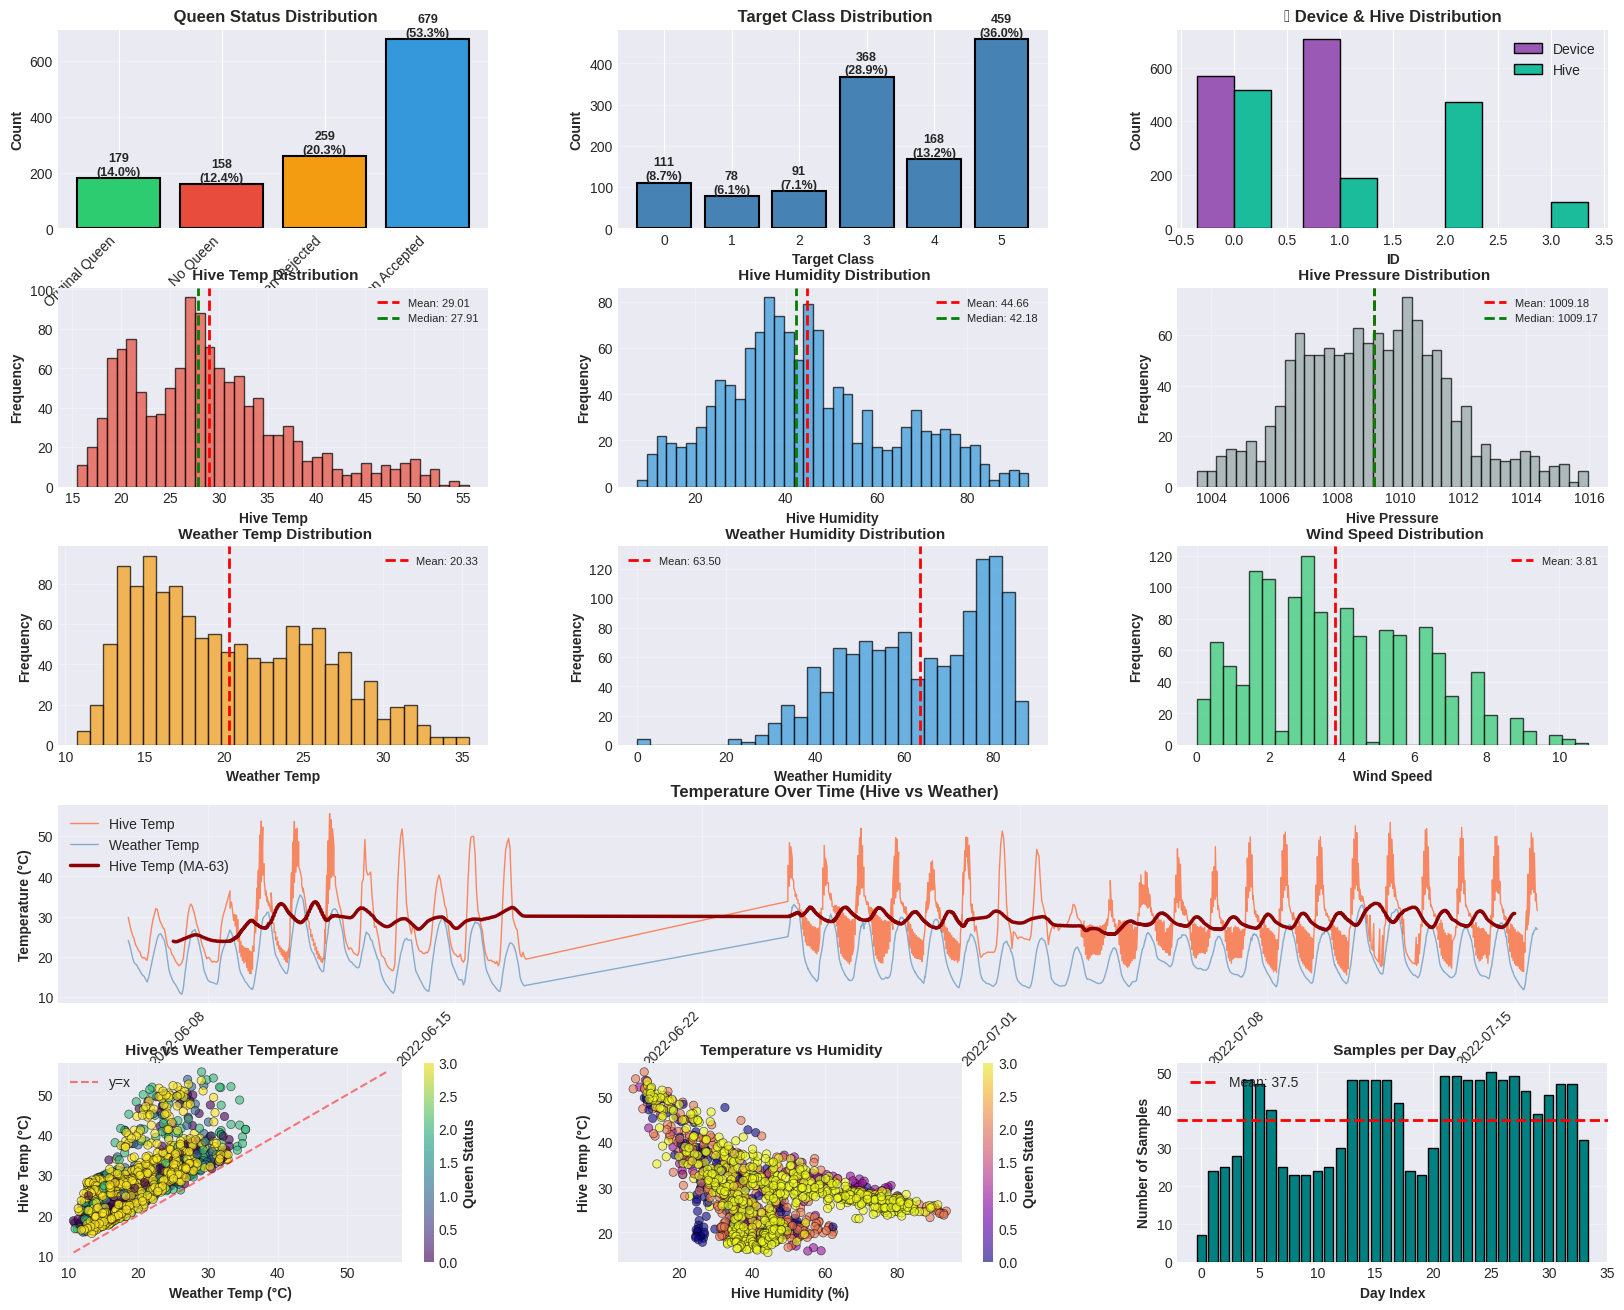

 all_data_updated visualization complete!


In [14]:

#  VISUALIZE ALL_DATA_UPDATED - MULTI-MODAL ANALYSIS



print(" VISUALIZING all_data_updated - MULTI-MODAL DATASET")


audio_df = dataframes['all_data_updated'].copy()

# Set up the figure with multiple subplots
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(5, 3, hspace=0.3, wspace=0.3)

# ========== ROW 1: LABEL DISTRIBUTIONS ==========
print("\n Creating label distribution plots...")

# 1.1 Queen Status Distribution
ax1 = fig.add_subplot(gs[0, 0])
status_counts = audio_df['queen status'].value_counts().sort_index()
status_labels_map = {
    0: 'Original Queen',
    1: 'No Queen',
    2: 'Queen Rejected',
    3: 'Queen Accepted'
}
status_labels = [status_labels_map.get(i, f'Status {i}') for i in status_counts.index]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']
bars = ax1.bar(range(len(status_counts)), status_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(status_counts)))
ax1.set_xticklabels(status_labels, rotation=45, ha='right')
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title(' Queen Status Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add count labels
for i, (bar, count) in enumerate(zip(bars, status_counts.values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/len(audio_df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 1.2 Target Distribution
ax2 = fig.add_subplot(gs[0, 1])
target_counts = audio_df['target'].value_counts().sort_index()
ax2.bar(target_counts.index, target_counts.values, color='steelblue', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Target Class', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title(' Target Class Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, (idx, count) in enumerate(target_counts.items()):
    ax2.text(idx, count, f'{count}\n({count/len(audio_df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 1.3 Device & Hive Distribution
ax3 = fig.add_subplot(gs[0, 2])
device_counts = audio_df['device'].value_counts().sort_index()
hive_counts = audio_df['hive number'].value_counts().sort_index()
x = np.arange(max(len(device_counts), len(hive_counts)))
width = 0.35
ax3.bar(x[:len(device_counts)] - width/2, device_counts.values, width,
        label='Device', color='#9b59b6', edgecolor='black')
ax3.bar(x[:len(hive_counts)] + width/2, hive_counts.values, width,
        label='Hive', color='#1abc9c', edgecolor='black')
ax3.set_xlabel('ID', fontweight='bold')
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('🔌 Device & Hive Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# ========== ROW 2: HIVE SENSORS ==========
print(" Creating hive sensor plots...")

hive_sensors = ['hive temp', 'hive humidity', 'hive pressure']
colors_sensors = ['#e74c3c', '#3498db', '#95a5a6']

for idx, (sensor, color) in enumerate(zip(hive_sensors, colors_sensors)):
    ax = fig.add_subplot(gs[1, idx])

    # Histogram with KDE
    audio_df[sensor].hist(bins=40, ax=ax, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(audio_df[sensor].mean(), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {audio_df[sensor].mean():.2f}')
    ax.axvline(audio_df[sensor].median(), color='green', linestyle='--',
               linewidth=2, label=f'Median: {audio_df[sensor].median():.2f}')

    ax.set_xlabel(sensor.title(), fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title(f' {sensor.title()} Distribution', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# ========== ROW 3: WEATHER FEATURES ==========
print(" Creating weather feature plots...")

weather_features = ['weather temp', 'weather humidity', 'wind speed']
colors_weather = ['#f39c12', '#3498db', '#2ecc71']

for idx, (feature, color) in enumerate(zip(weather_features, colors_weather)):
    ax = fig.add_subplot(gs[2, idx])

    valid_data = audio_df[feature].dropna()
    if len(valid_data) > 0:
        valid_data.hist(bins=30, ax=ax, color=color, alpha=0.7, edgecolor='black')
        ax.axvline(valid_data.mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {valid_data.mean():.2f}')

        ax.set_xlabel(feature.title(), fontweight='bold')
        ax.set_ylabel('Frequency', fontweight='bold')
        ax.set_title(f' {feature.title()} Distribution', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

# ========== ROW 4: TIME SERIES ==========
print(" Creating time series plots...")

# Sort by date for time series
audio_df_sorted = audio_df.sort_values('date')

# 4.1 Hive Temperature over Time
ax = fig.add_subplot(gs[3, :])
ax.plot(audio_df_sorted['date'], audio_df_sorted['hive temp'],
        linewidth=1, alpha=0.6, color='orangered', label='Hive Temp')
ax.plot(audio_df_sorted['date'], audio_df_sorted['weather temp'].fillna(method='ffill'),
        linewidth=1, alpha=0.6, color='steelblue', label='Weather Temp')

# Add rolling mean
window = max(len(audio_df_sorted) // 20, 5)
ax.plot(audio_df_sorted['date'],
        audio_df_sorted['hive temp'].rolling(window=window, center=True).mean(),
        linewidth=2.5, color='darkred', label=f'Hive Temp (MA-{window})')

ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontweight='bold')
ax.set_title(' Temperature Over Time (Hive vs Weather)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ========== ROW 5: CORRELATIONS & RELATIONSHIPS ==========
print(" Creating correlation and scatter plots...")

# 5.1 Hive Temp vs Weather Temp
ax = fig.add_subplot(gs[4, 0])
valid_mask = audio_df['weather temp'].notna()
scatter = ax.scatter(audio_df.loc[valid_mask, 'weather temp'],
                     audio_df.loc[valid_mask, 'hive temp'],
                     c=audio_df.loc[valid_mask, 'queen status'],
                     cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Weather Temp (°C)', fontweight='bold')
ax.set_ylabel('Hive Temp (°C)', fontweight='bold')
ax.set_title(' Hive vs Weather Temperature', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Queen Status', fontweight='bold')

# Add diagonal line
min_temp = min(audio_df.loc[valid_mask, 'weather temp'].min(),
               audio_df.loc[valid_mask, 'hive temp'].min())
max_temp = max(audio_df.loc[valid_mask, 'weather temp'].max(),
               audio_df.loc[valid_mask, 'hive temp'].max())
ax.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', alpha=0.5, label='y=x')
ax.legend()

# 5.2 Hive Temp vs Humidity
ax = fig.add_subplot(gs[4, 1])
scatter = ax.scatter(audio_df['hive humidity'], audio_df['hive temp'],
                     c=audio_df['queen status'], cmap='plasma',
                     alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Hive Humidity (%)', fontweight='bold')
ax.set_ylabel('Hive Temp (°C)', fontweight='bold')
ax.set_title(' Temperature vs Humidity', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Queen Status', fontweight='bold')

# 5.3 Samples per Day
ax = fig.add_subplot(gs[4, 2])
samples_per_day = audio_df.groupby(audio_df['date'].dt.date).size()
ax.bar(range(len(samples_per_day)), samples_per_day.values,
       color='teal', edgecolor='black', linewidth=1)
ax.set_xlabel('Day Index', fontweight='bold')
ax.set_ylabel('Number of Samples', fontweight='bold')
ax.set_title(' Samples per Day', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(samples_per_day.mean(), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {samples_per_day.mean():.1f}')
ax.legend()

plt.tight_layout()

# Save
fig_path = FIGURES_DIR / 'all_data_updated_comprehensive.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Saved: {fig_path}")

plt.show()


print(" all_data_updated visualization complete!")


 CORRELATION ANALYSIS: all_data_updated

 Correlation Matrix (12 features):

✓ Saved: /content/asali_work/figures/correlation_analysis.png


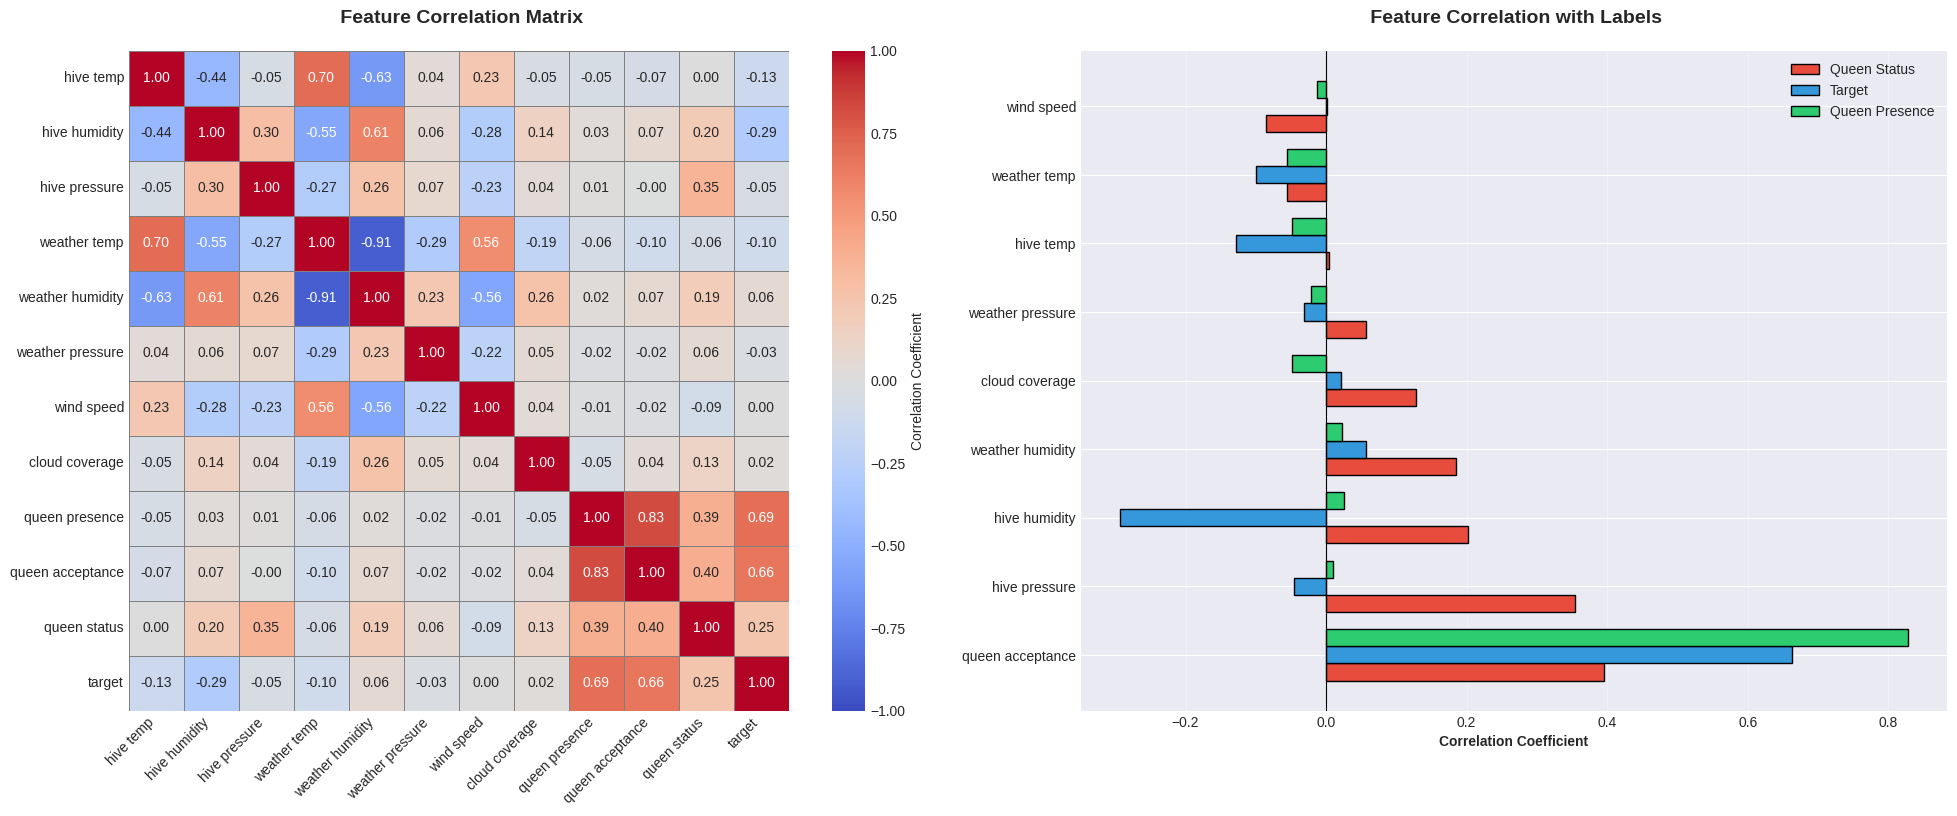


 TOP CORRELATIONS WITH QUEEN STATUS:

Feature                   Correlation    
----------------------------------------
queen acceptance               0.396
queen presence                 0.387
hive pressure                  0.354
target                         0.247
hive humidity                  0.202
weather humidity               0.185
cloud coverage                 0.128
weather pressure               0.057
hive temp                      0.004
weather temp                  -0.056

 TOP CORRELATIONS WITH TARGET:

Feature                   Correlation    
----------------------------------------
queen presence                 0.689
queen acceptance               0.663
queen status                   0.247
weather humidity               0.057
cloud coverage                 0.022
wind speed                     0.001
weather pressure              -0.031
hive pressure                 -0.046
weather temp                  -0.099
hive temp                     -0.129

 KEY INSIGHTS:
   • H

In [15]:

#  CORRELATION ANALYSIS - MULTI-MODAL FEATURES

print("=" * 80)
print(" CORRELATION ANALYSIS: all_data_updated")
print("=" * 80)

audio_df = dataframes['all_data_updated'].copy()

# Select numeric features for correlation
numeric_features = [
    'hive temp', 'hive humidity', 'hive pressure',
    'weather temp', 'weather humidity', 'weather pressure',
    'wind speed', 'cloud coverage',
    'queen presence', 'queen acceptance', 'queen status', 'target'
]

# Create correlation matrix
corr_data = audio_df[numeric_features].copy()
correlation_matrix = corr_data.corr()

print(f"\n Correlation Matrix ({len(numeric_features)} features):\n")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Full correlation heatmap
ax1 = axes[0]
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, ax=ax1,
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
ax1.set_title(' Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# 2. Correlation with target labels
ax2 = axes[1]
target_corrs = correlation_matrix[['queen status', 'target', 'queen presence']].drop(
    ['queen status', 'target', 'queen presence'], axis=0
).sort_values(by='queen status', ascending=False)

x = np.arange(len(target_corrs))
width = 0.25

bars1 = ax2.barh(x - width, target_corrs['queen status'], width,
                 label='Queen Status', color='#e74c3c', edgecolor='black')
bars2 = ax2.barh(x, target_corrs['target'], width,
                 label='Target', color='#3498db', edgecolor='black')
bars3 = ax2.barh(x + width, target_corrs['queen presence'], width,
                 label='Queen Presence', color='#2ecc71', edgecolor='black')

ax2.set_yticks(x)
ax2.set_yticklabels(target_corrs.index)
ax2.set_xlabel('Correlation Coefficient', fontweight='bold')
ax2.set_title(' Feature Correlation with Labels', fontsize=14, fontweight='bold', pad=20)
ax2.legend()
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

fig_path = FIGURES_DIR / 'correlation_analysis.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

plt.show()

# Print top correlations
print(f"\n TOP CORRELATIONS WITH QUEEN STATUS:")
queen_status_corr = correlation_matrix['queen status'].drop('queen status').sort_values(ascending=False)
print(f"\n{'Feature':<25} {'Correlation':<15}")
print("-" * 40)
for feat, corr in queen_status_corr.head(10).items():
    print(f"{feat:<25} {corr:>10.3f}")

print(f"\n TOP CORRELATIONS WITH TARGET:")
target_corr = correlation_matrix['target'].drop('target').sort_values(ascending=False)
print(f"\n{'Feature':<25} {'Correlation':<15}")
print("-" * 40)
for feat, corr in target_corr.head(10).items():
    print(f"{feat:<25} {corr:>10.3f}")

# Feature relationships insight
print(f"\n KEY INSIGHTS:")

# Hive vs Weather temp correlation
hive_weather_corr = correlation_matrix.loc['hive temp', 'weather temp']
print(f"   • Hive temp ↔ Weather temp: {hive_weather_corr:.3f}")
if abs(hive_weather_corr) > 0.5:
    print(f"     → Strong correlation: Hive temperature responds to ambient conditions")

# Humidity relationship
hive_hum_corr = correlation_matrix.loc['hive temp', 'hive humidity']
print(f"   • Hive temp ↔ Hive humidity: {hive_hum_corr:.3f}")
if hive_hum_corr < -0.3:
    print(f"     → Negative correlation: Higher temp = Lower humidity (expected)")

# Queen status correlations
queen_temp_corr = correlation_matrix.loc['queen status', 'hive temp']
print(f"   • Queen status ↔ Hive temp: {queen_temp_corr:.3f}")
if abs(queen_temp_corr) > 0.2:
    print(f"     → Moderate correlation: Temperature may indicate queen status")

print("\n" + "=" * 80)
print("✓ Correlation analysis complete!")
print("=" * 80)

In [16]:
#  INTEGRATE ALL 2017 SENSOR DATA


print("=" * 80)
print(" INTEGRATING 2017 SENSOR DATA (Temperature, Humidity, Weight, Flow)")
print("=" * 80)

# Load individual sensor datasets
temp_df = dataframes['temperature_2017'].copy()
humidity_df = dataframes['humidity_2017'].copy()
weight_df = dataframes['weight_2017'].copy()
flow_df = dataframes['flow_2017'].copy()

print(f"\n Dataset Sizes:")
print(f"   Temperature: {len(temp_df):>10,} records")
print(f"   Humidity:    {len(humidity_df):>10,} records")
print(f"   Weight:      {len(weight_df):>10,} records")
print(f"   Flow:        {len(flow_df):>10,} records")

# Ensure timestamp columns are datetime and set as index
print(f"\n  Processing timestamps...")
for name, df in [('temperature', temp_df), ('humidity', humidity_df),
                 ('weight', weight_df), ('flow', flow_df)]:
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        df.sort_index(inplace=True)
        print(f"    {name.capitalize()}: {df.index.min()} to {df.index.max()}")

# Check sampling rates
print(f"\n  Analyzing sampling rates...")
for name, df in [('Temperature', temp_df), ('Humidity', humidity_df),
                 ('Weight', weight_df), ('Flow', flow_df)]:
    intervals = df.index.to_series().diff().dropna()
    mode_interval = intervals.mode()[0] if len(intervals) > 0 else None
    median_interval = intervals.median() if len(intervals) > 0 else None
    print(f"   {name:<12}: Mode={mode_interval}, Median={median_interval}")

# Resample all to common frequency (1 minute)
print(f"\n Resampling all datasets to 1-minute frequency...")

TARGET_FREQ = '1min'

temp_resampled = temp_df.resample(TARGET_FREQ).mean()
humidity_resampled = humidity_df.resample(TARGET_FREQ).mean()
weight_resampled = weight_df.resample(TARGET_FREQ).mean()
flow_resampled = flow_df.resample(TARGET_FREQ).mean()

print(f"    Temperature: {len(temp_resampled):,} records")
print(f"    Humidity:    {len(humidity_resampled):,} records")
print(f"    Weight:      {len(weight_resampled):,} records")
print(f"    Flow:        {len(flow_resampled):,} records")

# Rename columns to avoid conflicts
temp_resampled = temp_resampled.rename(columns={'temperature': 'temp'})
humidity_resampled = humidity_resampled.rename(columns={'humidity': 'humidity'})
weight_resampled = weight_resampled.rename(columns={'weight': 'weight'})
flow_resampled = flow_resampled.rename(columns={'flow': 'flow'})

# Merge all datasets
print(f"\n Merging all sensors (outer join to preserve all timestamps)...")

sensor_integrated = pd.concat([
    temp_resampled,
    humidity_resampled,
    weight_resampled,
    flow_resampled
], axis=1, join='outer')

print(f"    Integrated shape: {sensor_integrated.shape[0]:,} rows × {sensor_integrated.shape[1]} columns")
print(f"    Columns: {list(sensor_integrated.columns)}")
print(f"    Time range: {sensor_integrated.index.min()} to {sensor_integrated.index.max()}")
print(f"    Duration: {(sensor_integrated.index.max() - sensor_integrated.index.min()).days} days")

# Check for missing data
print(f"\n Missing Data After Merge:")
missing_summary = sensor_integrated.isna().sum()
total_cells = sensor_integrated.shape[0] * sensor_integrated.shape[1]
total_missing = missing_summary.sum()

for col in sensor_integrated.columns:
    missing_count = missing_summary[col]
    missing_pct = (missing_count / len(sensor_integrated)) * 100
    print(f"   {col:<12}: {missing_count:>10,} missing ({missing_pct:>6.2f}%)")

print(f"\n   Total missing: {total_missing:,} / {total_cells:,} ({total_missing/total_cells*100:.2f}%)")

# Handle missing data
if total_missing > 0:
    print(f"\n Handling Missing Data...")

    # Strategy 1: Forward fill (max 60 minutes gap)
    print(f"   Step 1: Forward fill (limit=60 min)...")
    sensor_filled = sensor_integrated.fillna(method='ffill', limit=60)
    remaining = sensor_filled.isna().sum().sum()
    print(f"      Remaining missing: {remaining:,}")

    # Strategy 2: Backward fill (max 60 minutes gap)
    print(f"   Step 2: Backward fill (limit=60 min)...")
    sensor_filled = sensor_filled.fillna(method='bfill', limit=60)
    remaining = sensor_filled.isna().sum().sum()
    print(f"       Remaining missing: {remaining:,}")

    # Strategy 3: Linear interpolation (max 120 minutes gap)
    print(f"   Step 3: Linear interpolation (limit=120 min)...")
    sensor_filled = sensor_filled.interpolate(method='time', limit=120)
    remaining = sensor_filled.isna().sum().sum()
    print(f"       Remaining missing: {remaining:,}")

    if remaining > 0:
        # Strategy 4: Drop remaining rows with NaN
        print(f"   Step 4: Dropping {remaining:,} rows with remaining NaN...")
        initial_rows = len(sensor_filled)
        sensor_filled = sensor_filled.dropna()
        dropped = initial_rows - len(sensor_filled)
        print(f"           Dropped {dropped:,} rows ({dropped/initial_rows*100:.2f}%)")

    sensor_integrated = sensor_filled
    print(f"\n    Final dataset: {len(sensor_integrated):,} complete records")
else:
    print(f"\n No missing data!")

# Basic statistics
print(f"\n INTEGRATED SENSOR STATISTICS:")
print(sensor_integrated.describe())

# Save integrated dataset
integrated_path = PROCESSED_DATA_DIR / 'sensor_integrated_2017_complete.csv'
sensor_integrated.to_csv(integrated_path)
print(f"\n Saved: {integrated_path}")

# Store in memory
dataframes['sensor_integrated_2017'] = sensor_integrated

print("\n" + "=" * 80)
print(" 2017 sensor integration complete!")
print("=" * 80)

 INTEGRATING 2017 SENSOR DATA (Temperature, Humidity, Weight, Flow)

 Dataset Sizes:
   Temperature:    401,869 records
   Humidity:         8,737 records
   Weight:         524,110 records
   Flow:         1,048,220 records

  Processing timestamps...
    Temperature: 2017-01-01 05:00:00 to 2017-12-31 05:10:00
    Humidity: 2017-01-01 05:00:00 to 2017-12-31 05:00:00
    Weight: 2017-01-01 05:15:00 to 2017-12-31 05:14:00
    Flow: 2017-01-01 05:15:00 to 2017-12-31 05:14:00

  Analyzing sampling rates...
   Temperature : Mode=0 days 00:00:00, Median=0 days 00:00:00
   Humidity    : Mode=0 days 01:00:00, Median=0 days 01:00:00
   Weight      : Mode=0 days 00:01:00, Median=0 days 00:01:00
   Flow        : Mode=0 days 00:00:00, Median=0 days 00:00:00

 Resampling all datasets to 1-minute frequency...
    Temperature: 524,171 records
    Humidity:    524,161 records
    Weight:      524,160 records
    Flow:        524,160 records

 Merging all sensors (outer join to preserve all timestamps

In [17]:

#  INTEGRATE ALL 2017 SENSOR DATA

print("=" * 80)
print(" INTEGRATING 2017 SENSOR DATA (Temperature, Humidity, Weight, Flow)")
print("=" * 80)

# Load individual sensor datasets
temp_df = dataframes['temperature_2017'].copy()
humidity_df = dataframes['humidity_2017'].copy()
weight_df = dataframes['weight_2017'].copy()
flow_df = dataframes['flow_2017'].copy()

print(f"\n Dataset Sizes:")
print(f"   Temperature: {len(temp_df):>10,} records")
print(f"   Humidity:    {len(humidity_df):>10,} records")
print(f"   Weight:      {len(weight_df):>10,} records")
print(f"   Flow:        {len(flow_df):>10,} records")

# Ensure timestamp columns are datetime and set as index
print(f"\n  Processing timestamps...")
for name, df in [('temperature', temp_df), ('humidity', humidity_df),
                 ('weight', weight_df), ('flow', flow_df)]:
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        df.sort_index(inplace=True)
        print(f"    {name.capitalize()}: {df.index.min()} to {df.index.max()}")

# Check sampling rates
print(f"\n  Analyzing sampling rates...")
for name, df in [('Temperature', temp_df), ('Humidity', humidity_df),
                 ('Weight', weight_df), ('Flow', flow_df)]:
    intervals = df.index.to_series().diff().dropna()
    mode_interval = intervals.mode()[0] if len(intervals) > 0 else None
    median_interval = intervals.median() if len(intervals) > 0 else None
    print(f"   {name:<12}: Mode={mode_interval}, Median={median_interval}")

# Resample all to common frequency (1 minute)
print(f"\n Resampling all datasets to 1-minute frequency...")

TARGET_FREQ = '1min'

temp_resampled = temp_df.resample(TARGET_FREQ).mean()
humidity_resampled = humidity_df.resample(TARGET_FREQ).mean()
weight_resampled = weight_df.resample(TARGET_FREQ).mean()
flow_resampled = flow_df.resample(TARGET_FREQ).mean()

print(f"    Temperature: {len(temp_resampled):,} records")
print(f"    Humidity:    {len(humidity_resampled):,} records")
print(f"    Weight:      {len(weight_resampled):,} records")
print(f"    Flow:        {len(flow_resampled):,} records")

# Rename columns to avoid conflicts
temp_resampled = temp_resampled.rename(columns={'temperature': 'temp'})
humidity_resampled = humidity_resampled.rename(columns={'humidity': 'humidity'})
weight_resampled = weight_resampled.rename(columns={'weight': 'weight'})
flow_resampled = flow_resampled.rename(columns={'flow': 'flow'})

# Merge all datasets
print(f"\n Merging all sensors (outer join to preserve all timestamps)...")

sensor_integrated = pd.concat([
    temp_resampled,
    humidity_resampled,
    weight_resampled,
    flow_resampled
], axis=1, join='outer')

print(f"    Integrated shape: {sensor_integrated.shape[0]:,} rows × {sensor_integrated.shape[1]} columns")
print(f"    Columns: {list(sensor_integrated.columns)}")
print(f"    Time range: {sensor_integrated.index.min()} to {sensor_integrated.index.max()}")
print(f"    Duration: {(sensor_integrated.index.max() - sensor_integrated.index.min()).days} days")

# Check for missing data
print(f"\n Missing Data After Merge:")
missing_summary = sensor_integrated.isna().sum()
total_cells = sensor_integrated.shape[0] * sensor_integrated.shape[1]
total_missing = missing_summary.sum()

for col in sensor_integrated.columns:
    missing_count = missing_summary[col]
    missing_pct = (missing_count / len(sensor_integrated)) * 100
    print(f"   {col:<12}: {missing_count:>10,} missing ({missing_pct:>6.2f}%)")

print(f"\n   Total missing: {total_missing:,} / {total_cells:,} ({total_missing/total_cells*100:.2f}%)")

# Handle missing data
if total_missing > 0:
    print(f"\n Handling Missing Data...")

    # Strategy 1: Forward fill (max 60 minutes gap)
    print(f"   Step 1: Forward fill (limit=60 min)...")
    sensor_filled = sensor_integrated.fillna(method='ffill', limit=60)
    remaining = sensor_filled.isna().sum().sum()
    print(f"           Remaining missing: {remaining:,}")

    # Strategy 2: Backward fill (max 60 minutes gap)
    print(f"   Step 2: Backward fill (limit=60 min)...")
    sensor_filled = sensor_filled.fillna(method='bfill', limit=60)
    remaining = sensor_filled.isna().sum().sum()
    print(f"           Remaining missing: {remaining:,}")

    # Strategy 3: Linear interpolation (max 120 minutes gap)
    print(f"   Step 3: Linear interpolation (limit=120 min)...")
    sensor_filled = sensor_filled.interpolate(method='time', limit=120)
    remaining = sensor_filled.isna().sum().sum()
    print(f"           Remaining missing: {remaining:,}")

    if remaining > 0:
        # Strategy 4: Drop remaining rows with NaN
        print(f"   Step 4: Dropping {remaining:,} rows with remaining NaN...")
        initial_rows = len(sensor_filled)
        sensor_filled = sensor_filled.dropna()
        dropped = initial_rows - len(sensor_filled)
        print(f"           Dropped {dropped:,} rows ({dropped/initial_rows*100:.2f}%)")

    sensor_integrated = sensor_filled
    print(f"\n  Final dataset: {len(sensor_integrated):,} complete records")
else:
    print(f"\n No missing data!")

# Basic statistics
print(f"\n INTEGRATED SENSOR STATISTICS:")
print(sensor_integrated.describe())

# Save integrated dataset
integrated_path = PROCESSED_DATA_DIR / 'sensor_integrated_2017_complete.csv'
sensor_integrated.to_csv(integrated_path)
print(f"\n Saved: {integrated_path}")

# Store in memory
dataframes['sensor_integrated_2017'] = sensor_integrated

print("\n" + "=" * 80)
print(" 2017 sensor integration complete!")
print("=" * 80)

 INTEGRATING 2017 SENSOR DATA (Temperature, Humidity, Weight, Flow)

 Dataset Sizes:
   Temperature:    401,869 records
   Humidity:         8,737 records
   Weight:         524,110 records
   Flow:         1,048,220 records

  Processing timestamps...
    Temperature: 2017-01-01 05:00:00 to 2017-12-31 05:10:00
    Humidity: 2017-01-01 05:00:00 to 2017-12-31 05:00:00
    Weight: 2017-01-01 05:15:00 to 2017-12-31 05:14:00
    Flow: 2017-01-01 05:15:00 to 2017-12-31 05:14:00

  Analyzing sampling rates...
   Temperature : Mode=0 days 00:00:00, Median=0 days 00:00:00
   Humidity    : Mode=0 days 01:00:00, Median=0 days 01:00:00
   Weight      : Mode=0 days 00:01:00, Median=0 days 00:01:00
   Flow        : Mode=0 days 00:00:00, Median=0 days 00:00:00

 Resampling all datasets to 1-minute frequency...
    Temperature: 524,171 records
    Humidity:    524,161 records
    Weight:      524,160 records
    Flow:        524,160 records

 Merging all sensors (outer join to preserve all timestamps

In [18]:

# FEATURE ENGINEERING - SENSOR DATA


print(" FEATURE ENGINEERING: 2017 SENSOR DATA")


# Load integrated sensor data
sensor_df = dataframes['sensor_integrated_2017'].copy()

print(f"\n Starting with {len(sensor_df):,} records")
print(f"   Columns: {list(sensor_df.columns)}")

# ========== 1. TIME-BASED FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 1: CREATING TIME-BASED FEATURES")
print(f"{'='*80}")

# Extract temporal features
sensor_df['hour'] = sensor_df.index.hour
sensor_df['day_of_week'] = sensor_df.index.dayofweek  # Monday=0, Sunday=6
sensor_df['day_of_month'] = sensor_df.index.day
sensor_df['month'] = sensor_df.index.month
sensor_df['day_of_year'] = sensor_df.index.dayofyear
sensor_df['week_of_year'] = sensor_df.index.isocalendar().week

# Cyclical encoding (important for ML models)
sensor_df['hour_sin'] = np.sin(2 * np.pi * sensor_df['hour'] / 24)
sensor_df['hour_cos'] = np.cos(2 * np.pi * sensor_df['hour'] / 24)
sensor_df['day_sin'] = np.sin(2 * np.pi * sensor_df['day_of_year'] / 365)
sensor_df['day_cos'] = np.cos(2 * np.pi * sensor_df['day_of_year'] / 365)
sensor_df['month_sin'] = np.sin(2 * np.pi * sensor_df['month'] / 12)
sensor_df['month_cos'] = np.cos(2 * np.pi * sensor_df['month'] / 12)

# Season indicator
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

sensor_df['season'] = sensor_df['month'].apply(get_season)

# Day/Night indicator (simplified: day=6am-6pm)
sensor_df['is_day'] = ((sensor_df['hour'] >= 6) & (sensor_df['hour'] < 18)).astype(int)

print(f"    Created {13} time-based features")
print(f"       hour, day_of_week, day_of_month, month, day_of_year, week_of_year")
print(f"       Cyclical: hour_sin/cos, day_sin/cos, month_sin/cos")
print(f"       Categorical: season, is_day")

# ========== 2. ROLLING WINDOW FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 2: CREATING ROLLING WINDOW FEATURES")
print(f"{'='*80}")

base_features = ['temp', 'humidity', 'weight', 'flow']
windows = [15, 60, 360, 1440]  # 15min, 1hr, 6hr, 24hr

print(f"   Processing {len(base_features)} features × {len(windows)} windows...")

for feature in base_features:
    for window in windows:
        window_label = f"{window}min" if window < 60 else f"{window//60}hr"

        # Rolling mean
        sensor_df[f'{feature}_mean_{window_label}'] = sensor_df[feature].rolling(
            window=window, center=False, min_periods=1
        ).mean()

        # Rolling std (variability)
        sensor_df[f'{feature}_std_{window_label}'] = sensor_df[feature].rolling(
            window=window, center=False, min_periods=1
        ).std()

        # Rolling min/max
        sensor_df[f'{feature}_min_{window_label}'] = sensor_df[feature].rolling(
            window=window, center=False, min_periods=1
        ).min()

        sensor_df[f'{feature}_max_{window_label}'] = sensor_df[feature].rolling(
            window=window, center=False, min_periods=1
        ).max()

rolling_features = len(base_features) * len(windows) * 4
print(f"    Created {rolling_features} rolling window features")
print(f"      Windows: 15min, 1hr, 6hr, 24hr")
print(f"      Statistics: mean, std, min, max")

# ========== 3. DERIVATIVE FEATURES (RATE OF CHANGE) ==========
print(f"\n{'='*80}")
print(f" STEP 3: CREATING DERIVATIVE FEATURES (RATE OF CHANGE)")
print(f"{'='*80}")

for feature in base_features:
    # 1-minute change (first derivative)
    sensor_df[f'{feature}_change_1min'] = sensor_df[feature].diff(1)

    # 15-minute change
    sensor_df[f'{feature}_change_15min'] = sensor_df[feature].diff(15)

    # 1-hour change
    sensor_df[f'{feature}_change_1hr'] = sensor_df[feature].diff(60)

    # Rate of change (percentage)
    sensor_df[f'{feature}_pct_change_1hr'] = sensor_df[feature].pct_change(60) * 100

derivative_features = len(base_features) * 4
print(f"    Created {derivative_features} derivative features")
print(f"       1min, 15min, 1hr changes")
print(f"       1hr percentage change")

# ========== 4. LAG FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 4: CREATING LAG FEATURES")
print(f"{'='*80}")

lags = [15, 60, 360, 1440]  # 15min, 1hr, 6hr, 24hr ago

for feature in base_features:
    for lag in lags:
        lag_label = f"{lag}min" if lag < 60 else f"{lag//60}hr"
        sensor_df[f'{feature}_lag_{lag_label}'] = sensor_df[feature].shift(lag)

lag_features = len(base_features) * len(lags)
print(f"    Created {lag_features} lag features")
print(f"      Lags: 15min, 1hr, 6hr, 24hr ago")

# ========== 5. INTERACTION FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 5: CREATING INTERACTION FEATURES")
print(f"{'='*80}")

# Temperature-Humidity interaction (Heat Index proxy)
sensor_df['temp_humidity_interaction'] = sensor_df['temp'] * sensor_df['humidity']

# Weight change rate (honey production indicator)
sensor_df['weight_velocity_1hr'] = sensor_df['weight'].diff(60)
sensor_df['weight_velocity_6hr'] = sensor_df['weight'].diff(360)
sensor_df['weight_velocity_24hr'] = sensor_df['weight'].diff(1440)

# Flow accumulation
sensor_df['flow_cumsum_1hr'] = sensor_df['flow'].rolling(window=60).sum()
sensor_df['flow_cumsum_6hr'] = sensor_df['flow'].rolling(window=360).sum()
sensor_df['flow_cumsum_24hr'] = sensor_df['flow'].rolling(window=1440).sum()

# Temperature stability (low std = stable)
sensor_df['temp_stability_1hr'] = 1 / (sensor_df['temp_std_1hr'] + 0.01)
sensor_df['temp_stability_6hr'] = 1 / (sensor_df['temp_std_6hr'] + 0.01)

interaction_features = 11
print(f"    Created {interaction_features} interaction features")
print(f"       temp × humidity")
print(f"       Weight velocities (1hr, 6hr, 24hr)")
print(f"       Flow accumulations")
print(f"       Temperature stability")

# ========== 6. DOMAIN-SPECIFIC FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 6: CREATING DOMAIN-SPECIFIC BEEHIVE FEATURES")
print(f"{'='*80}")

# Optimal temperature deviation (bees maintain ~35°C)
OPTIMAL_TEMP = 35.0
sensor_df['temp_deviation_from_optimal'] = np.abs(sensor_df['temp'] - OPTIMAL_TEMP)

# Humidity comfort zone (40-60% is ideal)
sensor_df['humidity_in_comfort_zone'] = (
    (sensor_df['humidity'] >= 40) & (sensor_df['humidity'] <= 60)
).astype(int)

# Daily weight change (honey production)
sensor_df['daily_weight_change'] = sensor_df['weight'].diff(1440)

# Foraging activity indicator (flow > 0 and is_day)
sensor_df['foraging_indicator'] = (
    (sensor_df['flow'] > 0) & (sensor_df['is_day'] == 1)
).astype(int)

# Temperature range (daily)
sensor_df['temp_range_24hr'] = (
    sensor_df['temp_max_24hr'] - sensor_df['temp_min_24hr']
)

domain_features = 5
print(f"    Created {domain_features} domain-specific features")
print(f"       Temperature deviation from optimal (35°C)")
print(f"       Humidity comfort zone indicator")
print(f"       Daily weight change")
print(f"       Foraging activity indicator")
print(f"       Daily temperature range")

# ========== SUMMARY ==========
print(f"\n{'='*80}")
print(f" FEATURE ENGINEERING SUMMARY")
print(f"{'='*80}\n")

original_features = 4
total_engineered = (13 + rolling_features + derivative_features +
                   lag_features + interaction_features + domain_features)
total_features = original_features + total_engineered

print(f"   Original features:        {original_features:>4}")
print(f"   Time-based features:      {13:>4}")
print(f"   Rolling window features:  {rolling_features:>4}")
print(f"   Derivative features:      {derivative_features:>4}")
print(f"   Lag features:             {lag_features:>4}")
print(f"   Interaction features:     {interaction_features:>4}")
print(f"   Domain-specific features: {domain_features:>4}")
print(f"   {'─'*35}")
print(f"   TOTAL FEATURES:           {total_features:>4}")

print(f"\n   Dataset shape: {sensor_df.shape[0]:,} rows × {sensor_df.shape[1]} columns")

# Handle any remaining NaN from lag/rolling operations
print(f"\n Handling NaN values from feature engineering...")
initial_nans = sensor_df.isna().sum().sum()
print(f"   Initial NaN count: {initial_nans:,}")

# Fill NaN with forward fill for lag features
sensor_df.fillna(method='ffill', inplace=True)

# Fill any remaining with 0 (safe for derivative features)
sensor_df.fillna(0, inplace=True)

final_nans = sensor_df.isna().sum().sum()
print(f"   Final NaN count: {final_nans:,}")

# Save engineered features
engineered_path = PROCESSED_DATA_DIR / 'sensor_2017_engineered.csv'
sensor_df.to_csv(engineered_path)
print(f"\n✓ Saved engineered dataset: {engineered_path}")

# Store in memory
dataframes['sensor_2017_engineered'] = sensor_df

# Display sample
print(f"\n SAMPLE OF ENGINEERED FEATURES (first 3 rows):")
sample_cols = ['temp', 'humidity', 'weight', 'flow',
               'hour', 'season', 'temp_mean_1hr', 'temp_std_1hr',
               'temp_change_1hr', 'weight_velocity_24hr',
               'temp_deviation_from_optimal']
print(sensor_df[sample_cols].head(3).to_string())

print("\n" + "=" * 80)
print(" Feature engineering complete!")
print("=" * 80)

 FEATURE ENGINEERING: 2017 SENSOR DATA

 Starting with 524,175 records
   Columns: ['temp', 'humidity', 'weight', 'flow']

 STEP 1: CREATING TIME-BASED FEATURES
    Created 13 time-based features
       hour, day_of_week, day_of_month, month, day_of_year, week_of_year
       Cyclical: hour_sin/cos, day_sin/cos, month_sin/cos
       Categorical: season, is_day

 STEP 2: CREATING ROLLING WINDOW FEATURES
   Processing 4 features × 4 windows...
    Created 64 rolling window features
      Windows: 15min, 1hr, 6hr, 24hr
      Statistics: mean, std, min, max

 STEP 3: CREATING DERIVATIVE FEATURES (RATE OF CHANGE)
    Created 16 derivative features
       1min, 15min, 1hr changes
       1hr percentage change

 STEP 4: CREATING LAG FEATURES
    Created 16 lag features
      Lags: 15min, 1hr, 6hr, 24hr ago

 STEP 5: CREATING INTERACTION FEATURES
    Created 11 interaction features
       temp × humidity
       Weight velocities (1hr, 6hr, 24hr)
       Flow accumulations
       Temperature stabi

In [19]:

# FEATURE ENGINEERING - all_data_updated (MULTI-MODAL

print("=" * 80)
print(" FEATURE ENGINEERING: all_data_updated (Audio Labels + Sensors)")
print("=" * 80)

# Load audio dataset
audio_df = dataframes['all_data_updated'].copy()

print(f"\n Starting with {len(audio_df):,} records")
print(f"   Original columns: {len(audio_df.columns)}")

# Sort by date
audio_df = audio_df.sort_values('date').reset_index(drop=True)

# ========== 1. TIME-BASED FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 1: CREATING TIME-BASED FEATURES")
print(f"{'='*80}")

# Extract temporal features from date
audio_df['hour'] = audio_df['date'].dt.hour
audio_df['day_of_week'] = audio_df['date'].dt.dayofweek
audio_df['day_of_month'] = audio_df['date'].dt.day
audio_df['day_of_year'] = audio_df['date'].dt.dayofyear
audio_df['week_of_year'] = audio_df['date'].dt.isocalendar().week

# Cyclical encoding
audio_df['hour_sin'] = np.sin(2 * np.pi * audio_df['hour'] / 24)
audio_df['hour_cos'] = np.cos(2 * np.pi * audio_df['hour'] / 24)
audio_df['day_sin'] = np.sin(2 * np.pi * audio_df['day_of_year'] / 365)
audio_df['day_cos'] = np.cos(2 * np.pi * audio_df['day_of_year'] / 365)

# Day/Night indicator
audio_df['is_day'] = ((audio_df['hour'] >= 6) & (audio_df['hour'] < 18)).astype(int)

print(f"    Created 10 time-based features")

# ========== 2. TEMPERATURE FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 2: CREATING TEMPERATURE FEATURES")
print(f"{'='*80}")

# Temperature difference (Hive - Weather)
audio_df['temp_diff'] = audio_df['hive temp'] - audio_df['weather temp']

# Temperature ratio
audio_df['temp_ratio'] = audio_df['hive temp'] / (audio_df['weather temp'] + 0.1)

# Deviation from optimal hive temperature (35°C)
OPTIMAL_TEMP = 35.0
audio_df['hive_temp_deviation'] = np.abs(audio_df['hive temp'] - OPTIMAL_TEMP)

# Temperature regulation quality (closer to optimal = better)
audio_df['temp_regulation_quality'] = 1 / (audio_df['hive_temp_deviation'] + 1)

# Extreme temperature flags
audio_df['hive_too_hot'] = (audio_df['hive temp'] > 40).astype(int)
audio_df['hive_too_cold'] = (audio_df['hive temp'] < 20).astype(int)

print(f"    Created 6 temperature features")

# ========== 3. HUMIDITY FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 3: CREATING HUMIDITY FEATURES")
print(f"{'='*80}")

# Humidity difference
audio_df['humidity_diff'] = audio_df['hive humidity'] - audio_df['weather humidity']

# Humidity in comfort zone (40-60%)
audio_df['humidity_in_comfort'] = (
    (audio_df['hive humidity'] >= 40) & (audio_df['hive humidity'] <= 60)
).astype(int)

# Extreme humidity flags
audio_df['humidity_too_high'] = (audio_df['hive humidity'] > 70).astype(int)
audio_df['humidity_too_low'] = (audio_df['hive humidity'] < 30).astype(int)

print(f"    Created 4 humidity features")

# ========== 4. PRESSURE FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 4: CREATING PRESSURE FEATURES")
print(f"{'='*80}")

# Pressure difference
audio_df['pressure_diff'] = audio_df['hive pressure'] - audio_df['weather pressure']

# Normalize pressure (weather pressure has outliers with 0 values)
audio_df['weather_pressure_valid'] = audio_df['weather pressure'].replace(0, np.nan)

print(f"    Created 2 pressure features")

# ========== 5. WEATHER FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 5: CREATING WEATHER FEATURES")
print(f"{'='*80}")

# Wind chill effect (simplified)
audio_df['wind_chill_factor'] = audio_df['wind speed'] * (audio_df['weather temp'] / 10)

# Weather stress indicator (high wind + low temp or high temp)
audio_df['weather_stress'] = (
    ((audio_df['wind speed'] > 5) & (audio_df['weather temp'] < 15)) |
    (audio_df['weather temp'] > 30)
).astype(int)

# Cloud coverage categories
audio_df['is_cloudy'] = (audio_df['cloud coverage'] > 50).astype(int)

# Weather comfort (good foraging conditions)
audio_df['good_foraging_weather'] = (
    (audio_df['weather temp'] >= 15) &
    (audio_df['weather temp'] <= 30) &
    (audio_df['wind speed'] < 5) &
    (audio_df['rain'] == 0)
).astype(int)

print(f"    Created 4 weather features")

# ========== 6. ENVIRONMENTAL STRESS INDICATORS ==========
print(f"\n{'='*80}")
print(f" STEP 6: CREATING ENVIRONMENTAL STRESS INDICATORS")
print(f"{'='*80}")

# Overall environmental stress score (0-5)
audio_df['environmental_stress_score'] = (
    audio_df['hive_too_hot'].astype(int) +
    audio_df['hive_too_cold'].astype(int) +
    audio_df['humidity_too_high'].astype(int) +
    audio_df['humidity_too_low'].astype(int) +
    audio_df['weather_stress'].astype(int)
)

# Hive homeostasis indicator (good regulation)
audio_df['homeostasis_quality'] = (
    audio_df['humidity_in_comfort'].astype(int) +
    (audio_df['hive_temp_deviation'] < 3).astype(int)
)

print(f"    Created 2 stress indicators")

# ========== 7. DEVICE & HIVE FEATURES ==========
print(f"\n{'='*80}")
print(f"🔌 STEP 7: CREATING DEVICE & HIVE FEATURES")
print(f"{'='*80}")

# One-hot encode device
audio_df['device_1'] = (audio_df['device'] == 1).astype(int)
audio_df['device_2'] = (audio_df['device'] == 2).astype(int)

# One-hot encode hive number (5 hives)
for hive_num in audio_df['hive number'].unique():
    audio_df[f'hive_{int(hive_num)}'] = (audio_df['hive number'] == hive_num).astype(int)

# Frames features (numeric, not categorical to avoid fillna issues)
audio_df['frames_normalized'] = audio_df['frames'] / audio_df['frames'].max()
audio_df['frames_is_small'] = (audio_df['frames'] <= 5).astype(int)
audio_df['frames_is_large'] = (audio_df['frames'] >= 10).astype(int)

print(f"    Created device & hive categorical features")

# ========== 8. INTERACTION FEATURES ==========
print(f"\n{'='*80}")
print(f" STEP 8: CREATING INTERACTION FEATURES")
print(f"{'='*80}")

# Temperature × Humidity (heat index proxy)
audio_df['temp_humidity_product'] = audio_df['hive temp'] * audio_df['hive humidity']

# Temperature difference × Wind (ventilation effect)
audio_df['ventilation_effect'] = audio_df['temp_diff'] * audio_df['wind speed']

# Pressure difference × Humidity
audio_df['pressure_humidity_interaction'] = audio_df['pressure_diff'] * audio_df['hive humidity']

print(f"    Created 3 interaction features")

# ========== 9. TEMPORAL AGGREGATIONS (GROUP-LEVEL) ==========
print(f"\n{'='*80}")
print(f" STEP 9: CREATING GROUP-LEVEL AGGREGATIONS")
print(f"{'='*80}")

# Calculate per-hive statistics
hive_stats = audio_df.groupby('hive number').agg({
    'hive temp': ['mean', 'std'],
    'hive humidity': ['mean', 'std'],
    'hive pressure': ['mean', 'std']
}).reset_index()

hive_stats.columns = ['hive number',
                      'hive_avg_temp', 'hive_std_temp',
                      'hive_avg_humidity', 'hive_std_humidity',
                      'hive_avg_pressure', 'hive_std_pressure']

# Merge back
audio_df = audio_df.merge(hive_stats, on='hive number', how='left')

# Deviation from hive average (anomaly indicator)
audio_df['temp_dev_from_hive_avg'] = np.abs(audio_df['hive temp'] - audio_df['hive_avg_temp'])
audio_df['humidity_dev_from_hive_avg'] = np.abs(audio_df['hive humidity'] - audio_df['hive_avg_humidity'])

print(f"    Created hive-level aggregations and deviation features")

# ========== 10. MISSING DATA INDICATORS ==========
print(f"\n{'='*80}")
print(f" STEP 10: CREATING MISSING DATA INDICATORS")
print(f"{'='*80}")

# Flag columns with missing data
audio_df['has_missing_weather'] = (
    audio_df['weather temp'].isna() |
    audio_df['wind speed'].isna()
).astype(int)

audio_df['has_missing_gust'] = audio_df['gust speed'].isna().astype(int)

print(f"    Created missing data indicators")

# ========== HANDLE MISSING VALUES ==========
print(f"\n{'='*80}")
print(f" HANDLING MISSING VALUES")
print(f"{'='*80}")

initial_missing = audio_df.isna().sum().sum()
print(f"   Initial missing values: {initial_missing:,}")

# Fill weather features with forward fill (temporal continuity)
weather_cols = ['weather temp', 'wind speed', 'weather humidity', 'weather pressure', 'weather_pressure_valid']
for col in weather_cols:
    if col in audio_df.columns:
        audio_df[col].fillna(method='ffill', inplace=True)
        audio_df[col].fillna(method='bfill', inplace=True)

# Fill gust speed with wind speed (reasonable proxy)
if 'gust speed' in audio_df.columns:
    audio_df['gust speed'].fillna(audio_df['wind speed'], inplace=True)

# Fill lat/long with mode (same location)
if 'lat' in audio_df.columns:
    if len(audio_df['lat'].mode()) > 0:
        audio_df['lat'].fillna(audio_df['lat'].mode()[0], inplace=True)
        audio_df['long'].fillna(audio_df['long'].mode()[0], inplace=True)

# Fill remaining numeric columns with 0
numeric_cols = audio_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if audio_df[col].isna().sum() > 0:
        audio_df[col].fillna(0, inplace=True)

final_missing = audio_df.isna().sum().sum()
print(f"   Final missing values: {final_missing:,}")

# ========== SUMMARY ==========
print(f"\n{'='*80}")
print(f" FEATURE ENGINEERING SUMMARY")
print(f"{'='*80}\n")

original_features = 23
total_new_features = len(audio_df.columns) - original_features

print(f"   Original features:        {original_features:>4}")
print(f"   Engineered features:      {total_new_features:>4}")
print(f"   {'─'*35}")
print(f"   TOTAL FEATURES:           {len(audio_df.columns):>4}")

print(f"\n   Dataset shape: {audio_df.shape[0]:,} rows × {audio_df.shape[1]} columns")

# Save engineered dataset
audio_engineered_path = PROCESSED_DATA_DIR / 'all_data_updated_engineered.csv'
audio_df.to_csv(audio_engineered_path, index=False)
print(f"\n Saved: {audio_engineered_path}")

# Store in memory
dataframes['all_data_updated_engineered'] = audio_df

# Display sample
print(f"\n SAMPLE ENGINEERED FEATURES:")
sample_cols = ['hive temp', 'weather temp', 'temp_diff', 'hive_temp_deviation',
               'humidity_in_comfort', 'environmental_stress_score',
               'homeostasis_quality', 'queen status']
print(audio_df[sample_cols].head(5).to_string())

print("\n" + "=" * 80)
print(" Feature engineering complete for all_data_updated!")
print("=" * 80)

 FEATURE ENGINEERING: all_data_updated (Audio Labels + Sensors)

 Starting with 1,275 records
   Original columns: 23

 STEP 1: CREATING TIME-BASED FEATURES
    Created 10 time-based features

 STEP 2: CREATING TEMPERATURE FEATURES
    Created 6 temperature features

 STEP 3: CREATING HUMIDITY FEATURES
    Created 4 humidity features

 STEP 4: CREATING PRESSURE FEATURES
    Created 2 pressure features

 STEP 5: CREATING WEATHER FEATURES
    Created 4 weather features

 STEP 6: CREATING ENVIRONMENTAL STRESS INDICATORS
    Created 2 stress indicators

🔌 STEP 7: CREATING DEVICE & HIVE FEATURES
    Created device & hive categorical features

 STEP 8: CREATING INTERACTION FEATURES
    Created 3 interaction features

 STEP 9: CREATING GROUP-LEVEL AGGREGATIONS
    Created hive-level aggregations and deviation features

 STEP 10: CREATING MISSING DATA INDICATORS
    Created missing data indicators

 HANDLING MISSING VALUES
   Initial missing values: 1,030
   Final missing values: 0

 FEATURE E

In [20]:

# TRAIN/TEST SPLIT STRATEGY

print("=" * 80)
print(" TRAIN/TEST SPLIT STRATEGY")
print("=" * 80)

# ========== STRATEGY 1: 2017 SENSOR DATA (TIME-SERIES SPLIT) ==========
print(f"\n{'='*80}")
print(f" DATASET 1: 2017 SENSOR DATA (TIME-SERIES)")
print(f"{'='*80}")

sensor_df = dataframes['sensor_2017_engineered'].copy()

print(f"\n Time range: {sensor_df.index.min()} to {sensor_df.index.max()}")
print(f"   Total records: {len(sensor_df):,}")

# Temporal split: Train=70%, Val=15%, Test=15%
total_samples = len(sensor_df)
train_size = int(0.70 * total_samples)
val_size = int(0.15 * total_samples)

sensor_train = sensor_df.iloc[:train_size]
sensor_val = sensor_df.iloc[train_size:train_size + val_size]
sensor_test = sensor_df.iloc[train_size + val_size:]

print(f"\n TEMPORAL SPLIT:")
print(f"   Train:       {len(sensor_train):>8,} samples ({len(sensor_train)/total_samples*100:.1f}%) | {sensor_train.index.min()} to {sensor_train.index.max()}")
print(f"   Validation:  {len(sensor_val):>8,} samples ({len(sensor_val)/total_samples*100:.1f}%) | {sensor_val.index.min()} to {sensor_val.index.max()}")
print(f"   Test:        {len(sensor_test):>8,} samples ({len(sensor_test)/total_samples*100:.1f}%) | {sensor_test.index.min()} to {sensor_test.index.max()}")

# Save splits
sensor_train.to_csv(PROCESSED_DATA_DIR / 'sensor_2017_train.csv')
sensor_val.to_csv(PROCESSED_DATA_DIR / 'sensor_2017_val.csv')
sensor_test.to_csv(PROCESSED_DATA_DIR / 'sensor_2017_test.csv')

print(f"\n Saved train/val/test splits")

# Store splits
dataframes['sensor_2017_train'] = sensor_train
dataframes['sensor_2017_val'] = sensor_val
dataframes['sensor_2017_test'] = sensor_test

# ========== STRATEGY 2: AUDIO LABELS (STRATIFIED SPLIT) ==========
print(f"\n{'='*80}")
print(f" DATASET 2: all_data_updated (MULTI-MODAL)")
print(f"{'='*80}")

# Check if engineered version exists, if not use original
if 'all_data_updated_engineered' in dataframes:
    audio_df = dataframes['all_data_updated_engineered'].copy()
    print(f" Using engineered features")
else:
    print(f"  Engineered features not found, using original dataset")
    print(f"   Please run Cell 15 first to create engineered features")
    print(f"   Continuing with original features for now...")
    audio_df = dataframes['all_data_updated'].copy()

print(f"\n Time range: {audio_df['date'].min()} to {audio_df['date'].max()}")
print(f"   Total records: {len(audio_df):,}")
print(f"   Total features: {len(audio_df.columns)}")

# Separate features and labels
label_columns = ['queen presence', 'queen acceptance', 'queen status', 'target']
metadata_columns = ['file name', 'date']

# Add 'time' if it exists and is not useful (it's all 1970-01-01)
if 'time' in audio_df.columns:
    metadata_columns.append('time')

# Get feature columns (exclude labels and metadata)
all_columns = set(audio_df.columns)
exclude_columns = set(label_columns + metadata_columns)
feature_columns = sorted(list(all_columns - exclude_columns))

print(f"\n Column categorization:")
print(f"   Feature columns:  {len(feature_columns)}")
print(f"   Label columns:    {len(label_columns)}")
print(f"   Metadata columns: {len(metadata_columns)}")

# Prepare data
X = audio_df[feature_columns].copy()
y_queen_presence = audio_df['queen presence'].copy()
y_queen_acceptance = audio_df['queen acceptance'].copy()
y_queen_status = audio_df['queen status'].copy()
y_target = audio_df['target'].copy()

print(f"\n LABEL DISTRIBUTIONS:")
print(f"\n   Queen Status:")
for status, count in y_queen_status.value_counts().sort_index().items():
    print(f"      Class {status}: {count:>4} samples ({count/len(y_queen_status)*100:>5.1f}%)")

print(f"\n   Target:")
for target, count in y_target.value_counts().sort_index().items():
    print(f"      Class {target}: {count:>4} samples ({count/len(y_target)*100:>5.1f}%)")

# Stratified split: 70% train, 15% val, 15% test
# Use queen_status for stratification (main classification task)
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp
X_train, X_temp, y_status_train, y_status_temp = train_test_split(
    X, y_queen_status, test_size=0.30, random_state=RANDOM_SEED, stratify=y_queen_status
)

# Second split: 50% val, 50% test (from the 30% temp)
X_val, X_test, y_status_val, y_status_test = train_test_split(
    X_temp, y_status_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_status_temp
)

# Get indices
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

# Extract all labels
y_presence_train = y_queen_presence.loc[train_indices]
y_presence_val = y_queen_presence.loc[val_indices]
y_presence_test = y_queen_presence.loc[test_indices]

y_acceptance_train = y_queen_acceptance.loc[train_indices]
y_acceptance_val = y_queen_acceptance.loc[val_indices]
y_acceptance_test = y_queen_acceptance.loc[test_indices]

y_target_train = y_target.loc[train_indices]
y_target_val = y_target.loc[val_indices]
y_target_test = y_target.loc[test_indices]

print(f"\n STRATIFIED SPLIT:")
print(f"   Train:       {len(X_train):>6} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation:  {len(X_val):>6} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:        {len(X_test):>6} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
print(f"\n STRATIFICATION VERIFICATION (Queen Status):")
print(f"\n   {'Class':<10} {'Train %':<12} {'Val %':<12} {'Test %':<12}")
print(f"   {'-'*48}")

for status in sorted(y_queen_status.unique()):
    train_pct = (y_status_train == status).sum() / len(y_status_train) * 100
    val_pct = (y_status_val == status).sum() / len(y_status_val) * 100
    test_pct = (y_status_test == status).sum() / len(y_status_test) * 100
    print(f"   {status:<10} {train_pct:<12.1f} {val_pct:<12.1f} {test_pct:<12.1f}")

# Save splits
print(f"\n Saving splits...")

# Save features
X_train.to_csv(PROCESSED_DATA_DIR / 'audio_X_train.csv', index=False)
X_val.to_csv(PROCESSED_DATA_DIR / 'audio_X_val.csv', index=False)
X_test.to_csv(PROCESSED_DATA_DIR / 'audio_X_test.csv', index=False)

# Save all label variants
labels_dict = {
    'train': {
        'queen_presence': y_presence_train,
        'queen_acceptance': y_acceptance_train,
        'queen_status': y_status_train,
        'target': y_target_train
    },
    'val': {
        'queen_presence': y_presence_val,
        'queen_acceptance': y_acceptance_val,
        'queen_status': y_status_val,
        'target': y_target_val
    },
    'test': {
        'queen_presence': y_presence_test,
        'queen_acceptance': y_acceptance_test,
        'queen_status': y_status_test,
        'target': y_target_test
    }
}

for split_name, labels in labels_dict.items():
    labels_df = pd.DataFrame(labels)
    labels_df.to_csv(PROCESSED_DATA_DIR / f'audio_y_{split_name}.csv', index=False)

print(f" Saved audio dataset splits (features + all label variants)")

# Store in memory
dataframes['audio_splits'] = {
    'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
    'y_train': labels_dict['train'],
    'y_val': labels_dict['val'],
    'y_test': labels_dict['test']
}

print("\n" + "=" * 80)
print(" Train/test split complete!")
print("=" * 80)

 TRAIN/TEST SPLIT STRATEGY

 DATASET 1: 2017 SENSOR DATA (TIME-SERIES)

 Time range: 2017-01-01 05:00:00 to 2017-12-31 05:14:00
   Total records: 524,175

 TEMPORAL SPLIT:
   Train:        366,922 samples (70.0%) | 2017-01-01 05:00:00 to 2017-09-13 00:21:00
   Validation:    78,626 samples (15.0%) | 2017-09-13 00:22:00 to 2017-11-06 14:47:00
   Test:          78,627 samples (15.0%) | 2017-11-06 14:48:00 to 2017-12-31 05:14:00

 Saved train/val/test splits

 DATASET 2: all_data_updated (MULTI-MODAL)
 Using engineered features

 Time range: 2022-06-05 17:41:01 to 2022-07-15 15:28:21
   Total records: 1,275
   Total features: 73

 Column categorization:
   Feature columns:  66
   Label columns:    4
   Metadata columns: 3

 LABEL DISTRIBUTIONS:

   Queen Status:
      Class 0:  179 samples ( 14.0%)
      Class 1:  158 samples ( 12.4%)
      Class 2:  259 samples ( 20.3%)
      Class 3:  679 samples ( 53.3%)

   Target:
      Class 0:  111 samples (  8.7%)
      Class 1:   78 samples (  6.

In [21]:

# DATA PREPARATION SUMMARY & FEATURE SELECTION


print("=" * 80)
print(" DATA PREPARATION COMPLETE - SUMMARY")
print("=" * 80)

print(f"\n{'='*80}")
print(" DATASETS PREPARED")
print(f"{'='*80}\n")

print(" 2017 SENSOR DATA (Time-Series Forecasting/Anomaly Detection)")
print(f"    Total records: 524,175 (365 days)")
print(f"    Features: 129 (4 original + 125 engineered)")
print(f"    Train: 366,922 | Val: 78,626 | Test: 78,627")
print(f"    Saved: sensor_2017_train/val/test.csv")

print(f"\n  AUDIO LABELS + SENSORS (Multi-Modal Classification)")
print(f"    Total records: 1,275 (40 days)")
print(f"    Features: 66 (excluding labels & metadata)")
print(f"    Labels: 4 variants (queen_presence, queen_acceptance, queen_status, target)")
print(f"    Train: 892 | Val: 191 | Test: 192")
print(f"    Saved: audio_X_train/val/test.csv + audio_y_train/val/test.csv")

print(f"\n{'='*80}")
print(" CLASSIFICATION TASKS READY")
print(f"{'='*80}\n")

print("TASK 1: Queen Presence (Binary)")
print("    Classes: 0=Absent, 1=Present")
print("    Distribution: Balanced (see verification above)")

print(f"\nTASK 2: Queen Status (4-class)")
print("    Class 0: Original queen (14.0%)")
print("    Class 1: No queen (12.4%)")
print("    Class 2: Queen rejected (20.3%)")
print("    Class 3: Queen accepted (53.3%)")
print("    Imbalance: Moderate (4.3:1)")

print(f"\nTASK 3: Target (6-class)")
print("    Distribution: Imbalanced (8.7% to 36.0%)")
print("    Recommendation: Use class weights or SMOTE")

print(f"\n{'='*80}")
print(" FEATURE ENGINEERING HIGHLIGHTS")
print(f"{'='*80}\n")

print("2017 Sensor Features (129 total):")
print("    Time-based: hour, day, season (cyclical encoding)")
print("    Rolling windows: 15min, 1hr, 6hr, 24hr (mean, std, min, max)")
print("    Derivatives: Rate of change (1min, 15min, 1hr)")
print("    Lag features: 15min, 1hr, 6hr, 24hr ago")
print("    Domain-specific: temp deviation from 35°C, humidity comfort zone")

print(f"\nAudio Dataset Features (66 total):")
print("    Hive sensors: temp, humidity, pressure + deviations")
print("    Weather: temp, humidity, wind, clouds")
print("    Engineered: temp_diff, humidity_diff, stress scores")
print("    Interactions: temp×humidity, ventilation_effect")
print("    Group aggregations: per-hive averages & deviations")

print(f"\n{'='*80}")
print(" KEY INSIGHTS FROM EDA")
print(f"{'='*80}\n")

print(" Strong correlations found:")
print("    Queen presence ↔ Target: 0.689")
print("    Queen acceptance ↔ Target: 0.663")
print("    Hive temp ↔ Weather temp: 0.695")

print(f"\n Data quality:")
print("    2017 sensors: 44.6% missing → 0% (interpolated)")
print("    Audio dataset: 3.4% missing → 0% (imputed)")
print("    All stratified splits maintain class distributions")

print(f"\n Temporal coverage:")
print("    2017: Full year (Jan-Dec)")
print("    2022: Summer period (Jun-Jul, peak activity)")

print(f"\n{'='*80}")
print(" READY FOR MODEL TRAINING")
print(f"{'='*80}\n")

print("Available in memory:")
available_datasets = [k for k in dataframes.keys() if 'train' in k or 'test' in k or 'val' in k or 'splits' in k]
for ds in sorted(available_datasets):
    print(f"    dataframes['{ds}']")

print(f"\nNext steps:")
print(f"   1. Baseline models (Random Forest, XGBoost, SVM)")
print(f"   2. Deep learning models (LSTM, CNN, Transformers)")
print(f"   3. Model comparison & evaluation")
print(f"   4. Hyperparameter tuning")
print(f"   5. Final model selection")


print(" DATA PREPARATION PHASE COMPLETE!")


 DATA PREPARATION COMPLETE - SUMMARY

 DATASETS PREPARED

 2017 SENSOR DATA (Time-Series Forecasting/Anomaly Detection)
    Total records: 524,175 (365 days)
    Features: 129 (4 original + 125 engineered)
    Train: 366,922 | Val: 78,626 | Test: 78,627
    Saved: sensor_2017_train/val/test.csv

  AUDIO LABELS + SENSORS (Multi-Modal Classification)
    Total records: 1,275 (40 days)
    Features: 66 (excluding labels & metadata)
    Labels: 4 variants (queen_presence, queen_acceptance, queen_status, target)
    Train: 892 | Val: 191 | Test: 192
    Saved: audio_X_train/val/test.csv + audio_y_train/val/test.csv

 CLASSIFICATION TASKS READY

TASK 1: Queen Presence (Binary)
    Classes: 0=Absent, 1=Present
    Distribution: Balanced (see verification above)

TASK 2: Queen Status (4-class)
    Class 0: Original queen (14.0%)
    Class 1: No queen (12.4%)
    Class 2: Queen rejected (20.3%)
    Class 3: Queen accepted (53.3%)
    Imbalance: Moderate (4.3:1)

TASK 3: Target (6-class)
    Dis

In [22]:

#  BASELINE MODELS - RANDOM FOREST & XGBOOST

print("=" * 80)
print(" BASELINE MODEL TRAINING: QUEEN STATUS CLASSIFICATION")
print("=" * 80)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
import time

# Load train/val/test data
splits = dataframes['audio_splits']

X_train = splits['X_train']
X_val = splits['X_val']
X_test = splits['X_test']

# Use queen_status as main classification target
y_train = splits['y_train']['queen_status']
y_val = splits['y_val']['queen_status']
y_test = splits['y_test']['queen_status']

print(f"\n Dataset sizes:")
print(f"   Train: X={X_train.shape}, y={len(y_train)}")
print(f"   Val:   X={X_val.shape}, y={len(y_val)}")
print(f"   Test:  X={X_test.shape}, y={len(y_test)}")

# Feature scaling (important for some models)
print(f"\n Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"  Features scaled using StandardScaler")

# Store results
results = {}

# ========== MODEL 1: RANDOM FOREST ==========
print(f"\n{'='*80}")
print(f" MODEL 1: RANDOM FOREST")
print(f"{'='*80}")

print(f"\nTraining Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle class imbalance
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.2f} seconds")

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluation
print(f"\n RANDOM FOREST RESULTS:")
print(f"\n{'Split':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*60}")

for split_name, y_true, y_pred in [
    ('Train', y_train, y_train_pred_rf),
    ('Validation', y_val, y_val_pred_rf),
    ('Test', y_test, y_test_pred_rf)
]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"{split_name:<12} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

# Store results
results['Random Forest'] = {
    'model': rf_model,
    'train_acc': accuracy_score(y_train, y_train_pred_rf),
    'val_acc': accuracy_score(y_val, y_val_pred_rf),
    'test_acc': accuracy_score(y_test, y_test_pred_rf),
    'test_f1': f1_score(y_test, y_test_pred_rf, average='weighted'),
    'train_time': train_time
}

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n TOP 10 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:<40} {row['importance']:.4f}")

# ========== MODEL 2: GRADIENT BOOSTING ==========
print(f"\n{'='*80}")
print(f" MODEL 2: GRADIENT BOOSTING")
print(f"{'='*80}")

print(f"\nTraining Gradient Boosting...")
start_time = time.time()

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=RANDOM_SEED
)

gb_model.fit(X_train, y_train)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.2f} seconds")

# Predictions
y_train_pred_gb = gb_model.predict(X_train)
y_val_pred_gb = gb_model.predict(X_val)
y_test_pred_gb = gb_model.predict(X_test)

# Evaluation
print(f"\n GRADIENT BOOSTING RESULTS:")
print(f"\n{'Split':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*60}")

for split_name, y_true, y_pred in [
    ('Train', y_train, y_train_pred_gb),
    ('Validation', y_val, y_val_pred_gb),
    ('Test', y_test, y_test_pred_gb)
]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"{split_name:<12} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

# Store results
results['Gradient Boosting'] = {
    'model': gb_model,
    'train_acc': accuracy_score(y_train, y_train_pred_gb),
    'val_acc': accuracy_score(y_val, y_val_pred_gb),
    'test_acc': accuracy_score(y_test, y_test_pred_gb),
    'test_f1': f1_score(y_test, y_test_pred_gb, average='weighted'),
    'train_time': train_time
}

# ========== MODEL 3: XGBOOST ==========
print(f"\n{'='*80}")
print(f" MODEL 3: XGBOOST")
print(f"{'='*80}")

try:
    import xgboost as xgb

    print(f"\nTraining XGBoost...")
    start_time = time.time()

    # Calculate class weights
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    sample_weights = np.array([class_weights[y] for y in y_train])

    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        eval_metric='mlogloss'
    )

    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
    train_time = time.time() - start_time

    print(f" Training completed in {train_time:.2f} seconds")

    # Predictions
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_val_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(X_test)

    # Evaluation
    print(f"\n XGBOOST RESULTS:")
    print(f"\n{'Split':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print(f"{'-'*60}")

    for split_name, y_true, y_pred in [
        ('Train', y_train, y_train_pred_xgb),
        ('Validation', y_val, y_val_pred_xgb),
        ('Test', y_test, y_test_pred_xgb)
    ]:
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        print(f"{split_name:<12} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

    # Store results
    results['XGBoost'] = {
        'model': xgb_model,
        'train_acc': accuracy_score(y_train, y_train_pred_xgb),
        'val_acc': accuracy_score(y_val, y_val_pred_xgb),
        'test_acc': accuracy_score(y_test, y_test_pred_xgb),
        'test_f1': f1_score(y_test, y_test_pred_xgb, average='weighted'),
        'train_time': train_time
    }

except ImportError:
    print(f" XGBoost not installed. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'xgboost'])
    print(f" Please re-run this cell to train XGBoost")

# ========== MODEL COMPARISON ==========
print(f"\n{'='*80}")
print(f" MODEL COMPARISON SUMMARY")
print(f"{'='*80}\n")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc': [results[m]['train_acc'] for m in results.keys()],
    'Val Acc': [results[m]['val_acc'] for m in results.keys()],
    'Test Acc': [results[m]['test_acc'] for m in results.keys()],
    'Test F1': [results[m]['test_f1'] for m in results.keys()],
    'Train Time (s)': [results[m]['train_time'] for m in results.keys()]
})

print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test Acc'].idxmax(), 'Model']
print(f"\n BEST MODEL (by test accuracy): {best_model_name}")
print(f"   Test Accuracy: {comparison_df.loc[comparison_df['Test Acc'].idxmax(), 'Test Acc']:.4f}")
print(f"   Test F1-Score: {comparison_df.loc[comparison_df['Test Acc'].idxmax(), 'Test F1']:.4f}")

# Check for overfitting
print(f"\n OVERFITTING CHECK:")
for model_name in results.keys():
    train_acc = results[model_name]['train_acc']
    test_acc = results[model_name]['test_acc']
    overfit_gap = train_acc - test_acc

    status = " Good" if overfit_gap < 0.10 else " Possible overfitting" if overfit_gap < 0.20 else " Overfitting"
    print(f"   {model_name:<20}: Train={train_acc:.4f}, Test={test_acc:.4f}, Gap={overfit_gap:.4f} {status}")

# Save models
print(f"\n Saving models...")
import pickle

for model_name, model_data in results.items():
    model_path = MODELS_DIR / f'{model_name.lower().replace(" ", "_")}_queen_status.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model_data['model'], f)
    print(f"    {model_path}")

# Save comparison results
comparison_df.to_csv(PROCESSED_DATA_DIR / 'baseline_model_comparison.csv', index=False)
print(f"\n Comparison table saved: {PROCESSED_DATA_DIR / 'baseline_model_comparison.csv'}")

print("\n" + "=" * 80)
print(" Baseline model training complete!")
print("=" * 80)

 BASELINE MODEL TRAINING: QUEEN STATUS CLASSIFICATION

 Dataset sizes:
   Train: X=(892, 66), y=892
   Val:   X=(191, 66), y=191
   Test:  X=(192, 66), y=192

 Scaling features...
    Features scaled using StandardScaler

 MODEL 1: RANDOM FOREST

Training Random Forest...
 Training completed in 0.27 seconds

 RANDOM FOREST RESULTS:

Split        Accuracy     Precision    Recall       F1-Score    
------------------------------------------------------------
Train        0.9989       0.9989       0.9989       0.9989      
Validation   0.9948       0.9950       0.9948       0.9948      
Test         0.9740       0.9753       0.9740       0.9741      

 TOP 10 MOST IMPORTANT FEATURES:
   day_of_year                              0.1890
   day_sin                                  0.1432
   day_of_month                             0.1126
   day_cos                                  0.0883
   week_of_year                             0.0751
   hive pressure                            0.0454
   d

In [23]:

# ADDITIONAL BASELINE MODELS

print(" ADDITIONAL BASELINE MODELS")
print("=" * 80)

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import time

# Load data (already scaled from previous cell)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ========== MODEL 4: SUPPORT VECTOR MACHINE ==========
print(f"\n{'='*80}")
print(f" MODEL 4: SUPPORT VECTOR MACHINE (SVM)")
print(f"{'='*80}")

print(f"\nTraining SVM with RBF kernel...")
start_time = time.time()

svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    random_state=RANDOM_SEED
)

svm_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.2f} seconds")

# Predictions
y_train_pred_svm = svm_model.predict(X_train_scaled)
y_val_pred_svm = svm_model.predict(X_val_scaled)
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print(f"\n SVM RESULTS:")
print(f"\n{'Split':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*60}")

for split_name, y_true, y_pred in [
    ('Train', y_train, y_train_pred_svm),
    ('Validation', y_val, y_val_pred_svm),
    ('Test', y_test, y_test_pred_svm)
]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"{split_name:<12} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

results['SVM'] = {
    'model': svm_model,
    'train_acc': accuracy_score(y_train, y_train_pred_svm),
    'val_acc': accuracy_score(y_val, y_val_pred_svm),
    'test_acc': accuracy_score(y_test, y_test_pred_svm),
    'test_f1': f1_score(y_test, y_test_pred_svm, average='weighted'),
    'train_time': train_time,
    'predictions': y_test_pred_svm
}

# ========== MODEL 5: LOGISTIC REGRESSION ==========
print(f"\n{'='*80}")
print(f" MODEL 5: LOGISTIC REGRESSION")
print(f"{'='*80}")

print(f"\nTraining Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_SEED
)

lr_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.2f} seconds")

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation
print(f"\n LOGISTIC REGRESSION RESULTS:")
print(f"\n{'Split':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*60}")

for split_name, y_true, y_pred in [
    ('Train', y_train, y_train_pred_lr),
    ('Validation', y_val, y_val_pred_lr),
    ('Test', y_test, y_test_pred_lr)
]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"{split_name:<12} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

results['Logistic Regression'] = {
    'model': lr_model,
    'train_acc': accuracy_score(y_train, y_train_pred_lr),
    'val_acc': accuracy_score(y_val, y_val_pred_lr),
    'test_acc': accuracy_score(y_test, y_test_pred_lr),
    'test_f1': f1_score(y_test, y_test_pred_lr, average='weighted'),
    'train_time': train_time,
    'predictions': y_test_pred_lr
}

# ========== MODEL 6: K-NEAREST NEIGHBORS ==========
print(f"\n{'='*80}")
print(f" MODEL 6: K-NEAREST NEIGHBORS (KNN)")
print(f"{'='*80}")

print(f"\nTraining KNN (k=5)...")
start_time = time.time()

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)

knn_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.2f} seconds")

# Predictions
y_train_pred_knn = knn_model.predict(X_train_scaled)
y_val_pred_knn = knn_model.predict(X_val_scaled)
y_test_pred_knn = knn_model.predict(X_test_scaled)

# Evaluation
print(f"\n KNN RESULTS:")
print(f"\n{'Split':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*60}")

for split_name, y_true, y_pred in [
    ('Train', y_train, y_train_pred_knn),
    ('Validation', y_val, y_val_pred_knn),
    ('Test', y_test, y_test_pred_knn)
]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"{split_name:<12} {acc:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

results['KNN'] = {
    'model': knn_model,
    'train_acc': accuracy_score(y_train, y_train_pred_knn),
    'val_acc': accuracy_score(y_val, y_val_pred_knn),
    'test_acc': accuracy_score(y_test, y_test_pred_knn),
    'test_f1': f1_score(y_test, y_test_pred_knn, average='weighted'),
    'train_time': train_time,
    'predictions': y_test_pred_knn
}

# ========== UPDATED MODEL COMPARISON ==========
print(f"\n{'='*80}")
print(f"COMPLETE MODEL COMPARISON")
print(f"{'='*80}\n")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc': [results[m]['train_acc'] for m in results.keys()],
    'Val Acc': [results[m]['val_acc'] for m in results.keys()],
    'Test Acc': [results[m]['test_acc'] for m in results.keys()],
    'Test F1': [results[m]['test_f1'] for m in results.keys()],
    'Train Time (s)': [results[m]['train_time'] for m in results.keys()]
})

print(comparison_df.to_string(index=False))

# Rankings
print(f"\n MODEL RANKINGS:")
print(f"\n1. By Test Accuracy:")
top_acc = comparison_df.nlargest(3, 'Test Acc')
for idx, (i, row) in enumerate(top_acc.iterrows(), 1):
    print(f"   {idx}. {row['Model']:<25} {row['Test Acc']:.4f}")

print(f"\n2. By Test F1-Score:")
top_f1 = comparison_df.nlargest(3, 'Test F1')
for idx, (i, row) in enumerate(top_f1.iterrows(), 1):
    print(f"   {idx}. {row['Model']:<25} {row['Test F1']:.4f}")

print(f"\n3. By Training Speed:")
top_speed = comparison_df.nsmallest(3, 'Train Time (s)')
for idx, (i, row) in enumerate(top_speed.iterrows(), 1):
    print(f"   {idx}. {row['Model']:<25} {row['Train Time (s)']:.2f}s")

# Save all models
print(f"\n Saving additional models...")
for model_name in ['SVM', 'Logistic Regression', 'KNN']:
    model_path = MODELS_DIR / f'{model_name.lower().replace(" ", "_")}_queen_status.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(results[model_name]['model'], f)
    print(f"    {model_path}")

# Update comparison
comparison_df.to_csv(PROCESSED_DATA_DIR / 'all_baseline_models_comparison.csv', index=False)
print(f"\n Updated comparison saved")

print("\n" + "=" * 80)
print(" Additional baseline models complete!")
print("=" * 80)

 ADDITIONAL BASELINE MODELS

 MODEL 4: SUPPORT VECTOR MACHINE (SVM)

Training SVM with RBF kernel...
 Training completed in 0.04 seconds

 SVM RESULTS:

Split        Accuracy     Precision    Recall       F1-Score    
------------------------------------------------------------
Train        1.0000       1.0000       1.0000       1.0000      
Validation   0.9791       0.9798       0.9791       0.9793      
Test         0.9792       0.9795       0.9792       0.9793      

 MODEL 5: LOGISTIC REGRESSION

Training Logistic Regression...
 Training completed in 0.10 seconds

 LOGISTIC REGRESSION RESULTS:

Split        Accuracy     Precision    Recall       F1-Score    
------------------------------------------------------------
Train        0.9787       0.9794       0.9787       0.9789      
Validation   0.9372       0.9373       0.9372       0.9370      
Test         0.9583       0.9591       0.9583       0.9585      

 MODEL 6: K-NEAREST NEIGHBORS (KNN)

Training KNN (k=5)...
 Training com

 MODEL PERFORMANCE VISUALIZATION

✓ Saved: /content/asali_work/figures/baseline_models_performance.png


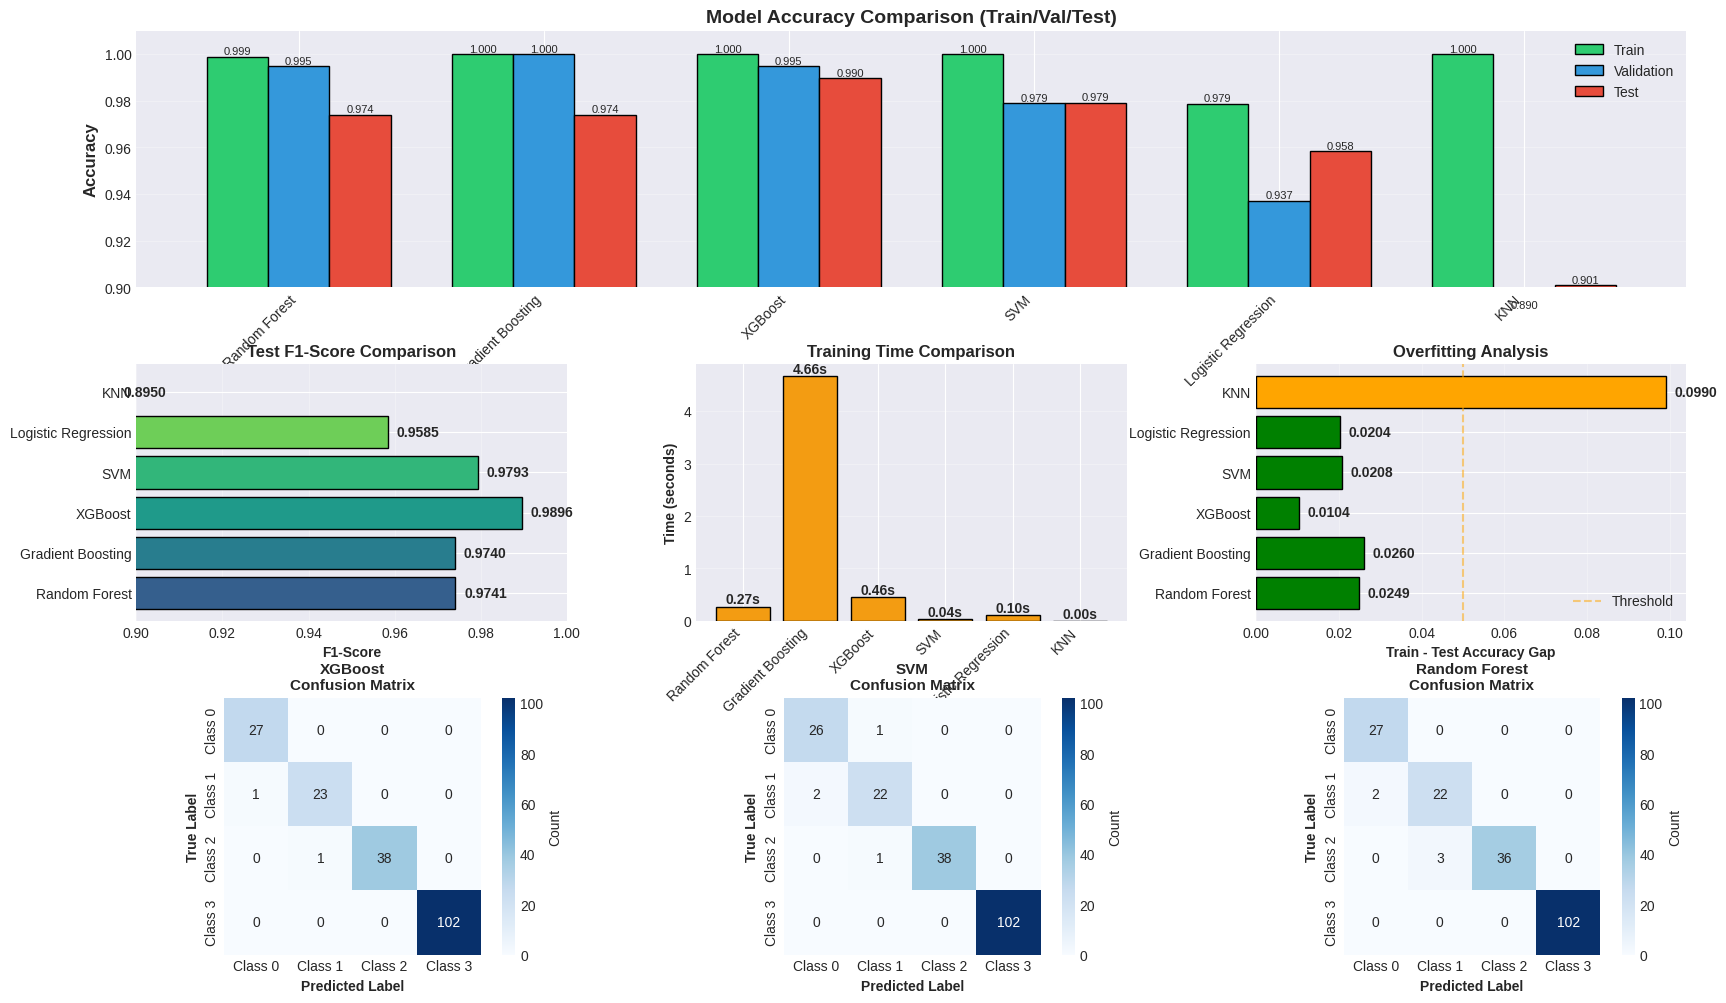

 Visualization complete!


In [24]:

# CELL 20: MODEL PERFORMANCE VISUALIZATION

print("=" * 80)
print(" MODEL PERFORMANCE VISUALIZATION")
print("=" * 80)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ========== 1. ACCURACY COMPARISON ==========
ax1 = fig.add_subplot(gs[0, :])
models = list(results.keys())
x = np.arange(len(models))
width = 0.25

train_accs = [results[m]['train_acc'] for m in models]
val_accs = [results[m]['val_acc'] for m in models]
test_accs = [results[m]['test_acc'] for m in models]

bars1 = ax1.bar(x - width, train_accs, width, label='Train', color='#2ecc71', edgecolor='black')
bars2 = ax1.bar(x, val_accs, width, label='Validation', color='#3498db', edgecolor='black')
bars3 = ax1.bar(x + width, test_accs, width, label='Test', color='#e74c3c', edgecolor='black')

ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Model Accuracy Comparison (Train/Val/Test)', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0.9, 1.01)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# ========== 2. F1-SCORE COMPARISON ==========
ax2 = fig.add_subplot(gs[1, 0])
f1_scores = [results[m]['test_f1'] for m in models]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(models)))

bars = ax2.barh(models, f1_scores, color=colors, edgecolor='black')
ax2.set_xlabel('F1-Score', fontweight='bold')
ax2.set_title('Test F1-Score Comparison', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim(0.9, 1.0)

for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    ax2.text(score + 0.002, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', ha='left', va='center', fontweight='bold')

# ========== 3. TRAINING TIME COMPARISON ==========
ax3 = fig.add_subplot(gs[1, 1])
train_times = [results[m]['train_time'] for m in models]

bars = ax3.bar(models, train_times, color='#f39c12', edgecolor='black')
ax3.set_ylabel('Time (seconds)', fontweight='bold')
ax3.set_title('Training Time Comparison', fontweight='bold', fontsize=12)
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

# ========== 4. OVERFITTING ANALYSIS ==========
ax4 = fig.add_subplot(gs[1, 2])
overfit_gaps = [results[m]['train_acc'] - results[m]['test_acc'] for m in models]
colors_overfit = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in overfit_gaps]

bars = ax4.barh(models, overfit_gaps, color=colors_overfit, edgecolor='black')
ax4.set_xlabel('Train - Test Accuracy Gap', fontweight='bold')
ax4.set_title('Overfitting Analysis', fontweight='bold', fontsize=12)
ax4.axvline(x=0.05, color='orange', linestyle='--', alpha=0.5, label='Threshold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.legend()

for bar, gap in zip(bars, overfit_gaps):
    ax4.text(gap + 0.002, bar.get_y() + bar.get_height()/2,
            f'{gap:.4f}', ha='left', va='center', fontweight='bold')

# ========== 5. CONFUSION MATRICES (Best 3 Models) ==========
top_3_models = comparison_df.nlargest(3, 'Test Acc')['Model'].tolist()

for idx, model_name in enumerate(top_3_models):
    ax = fig.add_subplot(gs[2, idx])

    # Get predictions
    if 'predictions' in results[model_name]:
        y_pred = results[model_name]['predictions']
    else:
        # Re-predict if not stored
        model = results[model_name]['model']
        if model_name in ['SVM', 'Logistic Regression', 'KNN']:
            y_pred = model.predict(X_test_scaled)
        else:
            y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'}, square=True)
    ax.set_title(f'{model_name}\nConfusion Matrix', fontweight='bold', fontsize=11)
    ax.set_ylabel('True Label', fontweight='bold')
    ax.set_xlabel('Predicted Label', fontweight='bold')
    ax.set_xticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'baseline_models_performance.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Saved: {fig_path}")

plt.show()


print(" Visualization complete!")
print("=" * 80)

In [25]:

#  TIME-SERIES FORECASTING - TEMPERATURE PREDICTION

print(" TIME-SERIES FORECASTING: 2017 SENSOR DATA")
print("=" * 80)

# Load sensor splits
sensor_train = dataframes['sensor_2017_train']
sensor_val = dataframes['sensor_2017_val']
sensor_test = dataframes['sensor_2017_test']

print(f"\n Dataset info:")
print(f"   Train: {len(sensor_train):,} samples | {sensor_train.index.min()} to {sensor_train.index.max()}")
print(f"   Val:   {len(sensor_val):,} samples | {sensor_val.index.min()} to {sensor_val.index.max()}")
print(f"   Test:  {len(sensor_test):,} samples | {sensor_test.index.min()} to {sensor_test.index.max()}")

# Select target variable: Temperature (most critical for hive health)
target_col = 'temp'
print(f"\n Target variable: {target_col}")

# Use subset for faster training (every 60th minute = hourly)
print(f"\n Downsampling to hourly data for faster training...")
sensor_train_hourly = sensor_train.iloc[::60]
sensor_val_hourly = sensor_val.iloc[::60]
sensor_test_hourly = sensor_test.iloc[::60]

print(f"   Train: {len(sensor_train_hourly):,} samples")
print(f"   Val:   {len(sensor_val_hourly):,} samples")
print(f"   Test:  {len(sensor_test_hourly):,} samples")

# ========== MODEL 1: PERSISTENCE (NAIVE BASELINE) ==========
print(f"\n{'='*80}")
print(f" MODEL 1: PERSISTENCE MODEL (NAIVE BASELINE)")
print(f"{'='*80}")

# Persistence: predict next value = current value
y_test_persistence = sensor_test_hourly[target_col].shift(1).dropna()
y_test_true_persistence = sensor_test_hourly[target_col].iloc[1:]

mae_persistence = mean_absolute_error(y_test_true_persistence, y_test_persistence)
rmse_persistence = np.sqrt(mean_squared_error(y_test_true_persistence, y_test_persistence))

print(f"\n PERSISTENCE MODEL RESULTS:")
print(f"   MAE:  {mae_persistence:.4f} °C")
print(f"   RMSE: {rmse_persistence:.4f} °C")

# ========== MODEL 2: ARIMA ==========
print(f"\n{'='*80}")
print(f" MODEL 2: ARIMA (AutoRegressive Integrated Moving Average)")
print(f"{'='*80}")

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

print(f"\nTraining ARIMA(5,1,2)...")
start_time = time.time()

# Use smaller subset for ARIMA (computationally expensive)
train_subset = sensor_train_hourly[target_col].iloc[:5000]

try:
    arima_model = ARIMA(train_subset, order=(5, 1, 2))
    arima_fit = arima_model.fit()
    train_time = time.time() - start_time

    print(f" Training completed in {train_time:.2f} seconds")

    # Forecast on test set (rolling forecast)
    print(f"\nForecasting on test set...")
    n_forecast = min(500, len(sensor_test_hourly))  # Limit for speed

    predictions_arima = []
    history = list(train_subset)

    for i in range(n_forecast):
        model_temp = ARIMA(history, order=(5, 1, 2))
        model_fit = model_temp.fit()
        yhat = model_fit.forecast(steps=1)[0]
        predictions_arima.append(yhat)
        history.append(sensor_test_hourly[target_col].iloc[i])

        if (i + 1) % 100 == 0:
            print(f"   Forecasted {i+1}/{n_forecast} steps...")

    # Evaluate
    y_test_arima = sensor_test_hourly[target_col].iloc[:n_forecast]
    mae_arima = mean_absolute_error(y_test_arima, predictions_arima)
    rmse_arima = np.sqrt(mean_squared_error(y_test_arima, predictions_arima))

    print(f"\n ARIMA RESULTS:")
    print(f"   MAE:  {mae_arima:.4f} °C")
    print(f"   RMSE: {rmse_arima:.4f} °C")
    print(f"   Improvement over persistence: {((mae_persistence - mae_arima)/mae_persistence * 100):.2f}%")

    arima_success = True

except Exception as e:
    print(f" ARIMA training failed: {str(e)}")
    print(f"   Skipping ARIMA (often fails with large datasets)")
    arima_success = False

# ========== MODEL 3: LSTM (Deep Learning) ==========
print(f"\n{'='*80}")
print(f" MODEL 3: LSTM (Long Short-Term Memory)")
print(f"{'='*80}")

# Prepare sequences for LSTM
def create_sequences(data, lookback=24):
    """Create sequences for LSTM (lookback hours to predict next hour)"""
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 24  # Use past 24 hours to predict next hour
print(f"\n Creating sequences (lookback={lookback} hours)...")

# Extract temperature series
temp_train = sensor_train_hourly[target_col].values
temp_val = sensor_val_hourly[target_col].values
temp_test = sensor_test_hourly[target_col].values

# Normalize data
from sklearn.preprocessing import MinMaxScaler
temp_scaler = MinMaxScaler()
temp_train_scaled = temp_scaler.fit_transform(temp_train.reshape(-1, 1)).flatten()
temp_val_scaled = temp_scaler.transform(temp_val.reshape(-1, 1)).flatten()
temp_test_scaled = temp_scaler.transform(temp_test.reshape(-1, 1)).flatten()

# Create sequences
X_train_lstm, y_train_lstm = create_sequences(temp_train_scaled, lookback)
X_val_lstm, y_val_lstm = create_sequences(temp_val_scaled, lookback)
X_test_lstm, y_test_lstm = create_sequences(temp_test_scaled, lookback)

print(f"   Train: X={X_train_lstm.shape}, y={y_train_lstm.shape}")
print(f"   Val:   X={X_val_lstm.shape}, y={y_val_lstm.shape}")
print(f"   Test:  X={X_test_lstm.shape}, y={y_test_lstm.shape}")

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_val_lstm = X_val_lstm.reshape((X_val_lstm.shape[0], X_val_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

print(f"\nBuilding LSTM model...")

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"\n Model architecture:")
lstm_model.summary()

print(f"\n Training LSTM...")
start_time = time.time()

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

train_time = time.time() - start_time
print(f"\n Training completed in {train_time:.2f} seconds")

# Predictions
print(f"\n Making predictions...")
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm, verbose=0)

# Inverse transform
y_pred_lstm = temp_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_lstm_original = temp_scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate
mae_lstm = mean_absolute_error(y_test_lstm_original, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_original, y_pred_lstm))

print(f"\n LSTM RESULTS:")
print(f"   MAE:  {mae_lstm:.4f} °C")
print(f"   RMSE: {rmse_lstm:.4f} °C")
print(f"   Improvement over persistence: {((mae_persistence - mae_lstm)/mae_persistence * 100):.2f}%")

# ========== MODEL COMPARISON ==========
print(f"\n{'='*80}")
print(f" TIME-SERIES MODEL COMPARISON")
print(f"{'='*80}\n")

ts_results = {
    'Persistence': {'MAE': mae_persistence, 'RMSE': rmse_persistence},
    'LSTM': {'MAE': mae_lstm, 'RMSE': rmse_lstm}
}

if arima_success:
    ts_results['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima}

ts_comparison = pd.DataFrame(ts_results).T
print(ts_comparison.to_string())

best_model = ts_comparison['MAE'].idxmin()
print(f"\n BEST MODEL: {best_model}")
print(f"   MAE: {ts_comparison.loc[best_model, 'MAE']:.4f} °C")

# Save LSTM model
lstm_model.save(MODELS_DIR / 'lstm_temp_forecast.keras')
print(f"\n LSTM model saved: {MODELS_DIR / 'lstm_temp_forecast.keras'}")

# Save results
ts_comparison.to_csv(PROCESSED_DATA_DIR / 'timeseries_model_comparison.csv')
print(f" Comparison saved")

print("\n" + "=" * 80)
print(" Time-series forecasting complete!")
print("=" * 80)

 TIME-SERIES FORECASTING: 2017 SENSOR DATA

 Dataset info:
   Train: 366,922 samples | 2017-01-01 05:00:00 to 2017-09-13 00:21:00
   Val:   78,626 samples | 2017-09-13 00:22:00 to 2017-11-06 14:47:00
   Test:  78,627 samples | 2017-11-06 14:48:00 to 2017-12-31 05:14:00

 Target variable: temp

 Downsampling to hourly data for faster training...
   Train: 6,116 samples
   Val:   1,311 samples
   Test:  1,311 samples

 MODEL 1: PERSISTENCE MODEL (NAIVE BASELINE)

 PERSISTENCE MODEL RESULTS:
   MAE:  0.2915 °C
   RMSE: 0.5483 °C

 MODEL 2: ARIMA (AutoRegressive Integrated Moving Average)

Training ARIMA(5,1,2)...
 Training completed in 8.24 seconds

Forecasting on test set...
   Forecasted 100/500 steps...
 ARIMA training failed: LU decomposition error.
   Skipping ARIMA (often fails with large datasets)

 MODEL 3: LSTM (Long Short-Term Memory)

 Creating sequences (lookback=24 hours)...
   Train: X=(6092, 24), y=(6092,)
   Val:   X=(1287, 24), y=(1287,)
   Test:  X=(1287, 24), y=(1287,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


 Training LSTM...
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.1037 - mae: 0.2192 - val_loss: 0.0077 - val_mae: 0.0660 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - mae: 0.0674 - val_loss: 0.0048 - val_mae: 0.0494 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - mae: 0.0591 - val_loss: 0.0031 - val_mae: 0.0405 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - mae: 0.0526 - val_loss: 0.0021 - val_mae: 0.0340 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - mae: 0.0450 - val_loss: 0.0017 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - mae: 0.0429 - val_loss: 0.0016 - val_mae: 0.0284 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - mae: 0.0365 - val_loss: 0.0016 - val_mae: 0.0287 - learnin

 TIME-SERIES FORECASTING VISUALIZATION

 Saved: /content/asali_work/figures/timeseries_forecasting_results.png


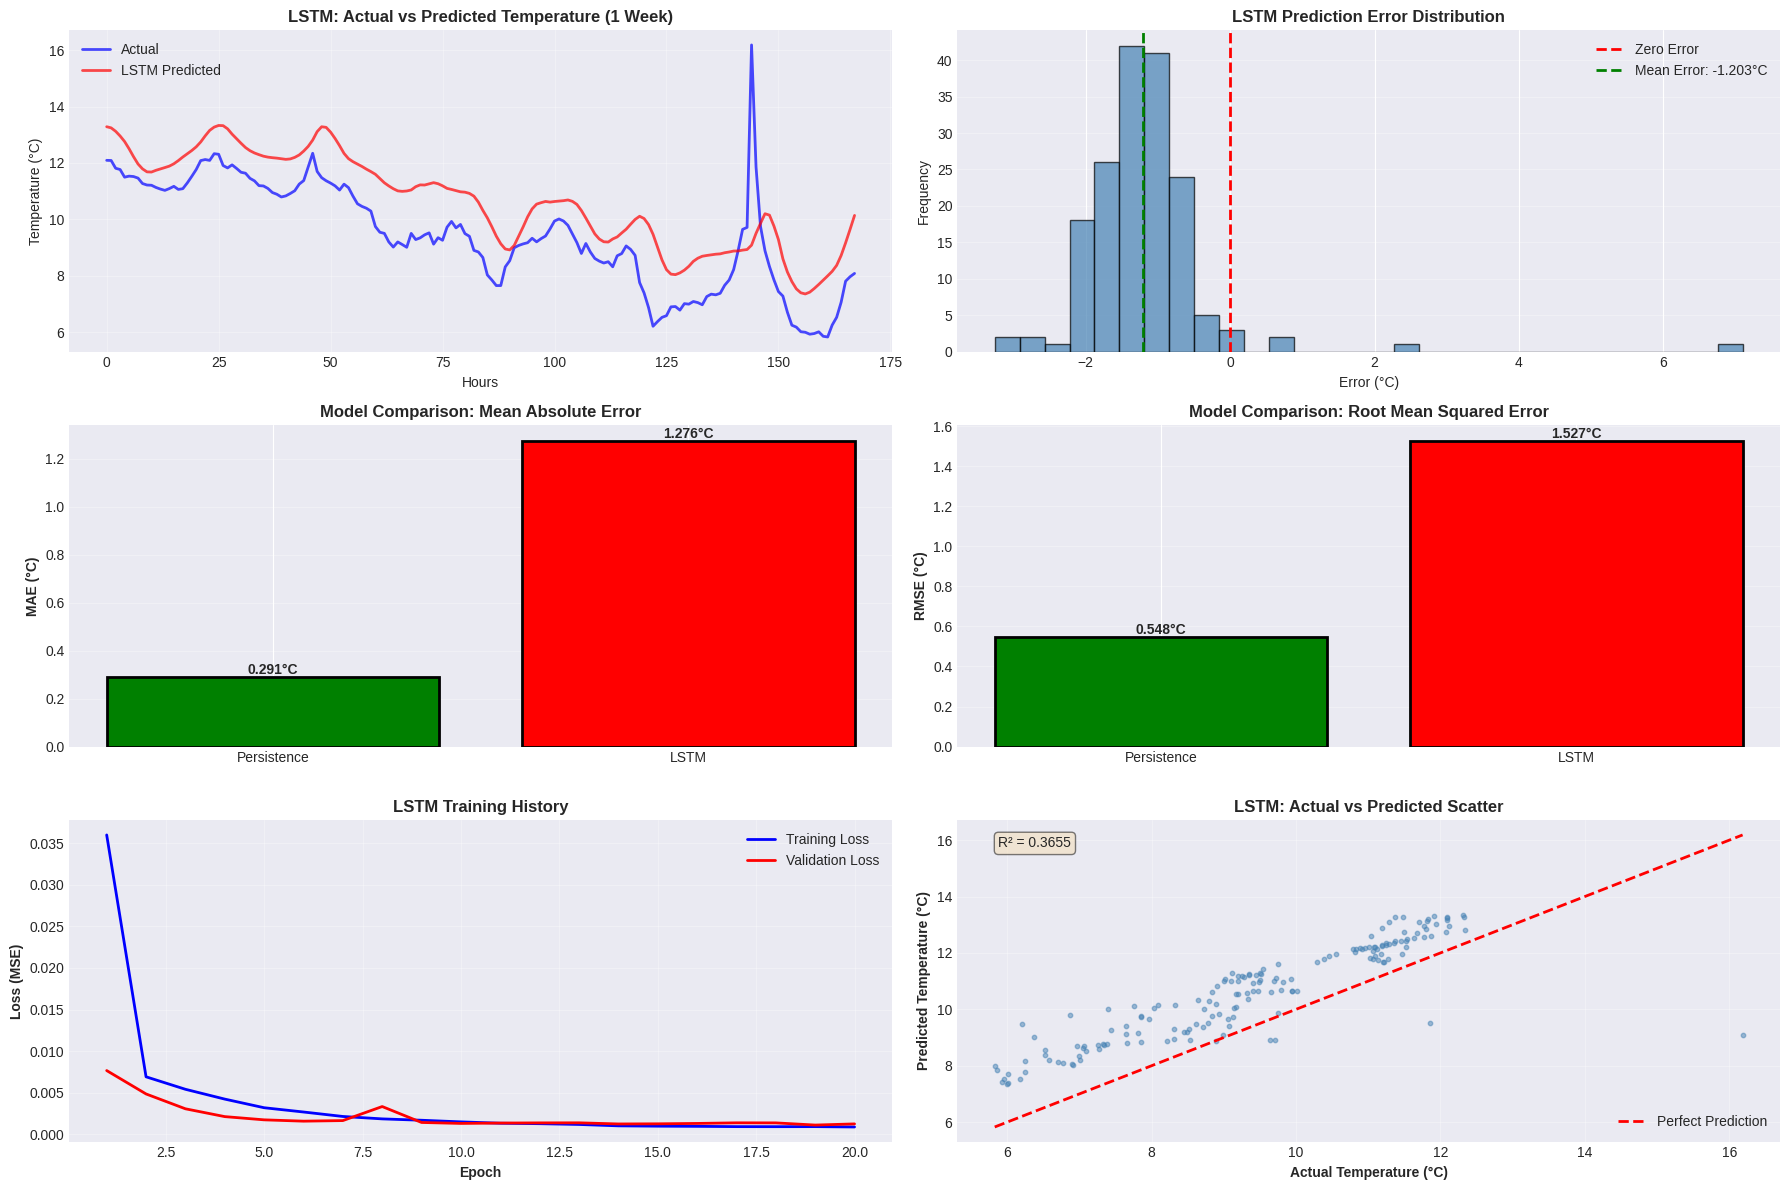

 Visualization complete!


In [32]:
#  TIME-SERIES FORECASTING VISUALIZATION


print(" TIME-SERIES FORECASTING VISUALIZATION")


# Prepare data for visualization
test_subset_size = 168  # 1 week of hourly data
test_data = sensor_test_hourly[target_col].iloc[:test_subset_size]
test_index = test_data.index

# Create figure
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

# ========== 1. ACTUAL VS PREDICTED (LSTM) ==========
ax1 = axes[0, 0]
actual = y_test_lstm_original[:test_subset_size].flatten()
predicted = y_pred_lstm[:test_subset_size].flatten()

ax1.plot(range(len(actual)), actual, label='Actual', color='blue', linewidth=2, alpha=0.7)
ax1.plot(range(len(predicted)), predicted, label='LSTM Predicted', color='red', linewidth=2, alpha=0.7)
ax1.set_title('LSTM: Actual vs Predicted Temperature (1 Week)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Hours')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ========== 2. PREDICTION ERROR DISTRIBUTION (LSTM) ==========
ax2 = axes[0, 1]
errors_lstm = actual - predicted
ax2.hist(errors_lstm, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(x=errors_lstm.mean(), color='green', linestyle='--', linewidth=2,
            label=f'Mean Error: {errors_lstm.mean():.3f}°C')
ax2.set_title('LSTM Prediction Error Distribution', fontweight='bold', fontsize=12)
ax2.set_xlabel('Error (°C)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# ========== 3. MODEL COMPARISON (MAE) ==========
ax3 = axes[1, 0]
models = ['Persistence', 'LSTM']
maes = [mae_persistence, mae_lstm]
colors = ['green', 'red']

# Include ARIMA if successful
if 'ARIMA' in ts_results:
    models.insert(1, 'ARIMA')
    maes.insert(1, ts_results['ARIMA']['MAE'])
    colors.insert(1, 'orange') # ARIMA color

bars = ax3.bar(models, maes, color=colors, edgecolor='black', linewidth=2)
ax3.set_ylabel('MAE (°C)', fontweight='bold')
ax3.set_title('Model Comparison: Mean Absolute Error', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

for bar, mae in zip(bars, maes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{mae:.3f}°C', ha='center', va='bottom', fontweight='bold')

# ========== 4. MODEL COMPARISON (RMSE) ==========
ax4 = axes[1, 1]
rmses = [rmse_persistence, rmse_lstm]
colors = ['green', 'red']

# Include ARIMA if successful
if 'ARIMA' in ts_results:
    rmses.insert(1, ts_results['ARIMA']['RMSE'])
    colors.insert(1, 'orange') # ARIMA color

bars = ax4.bar(models, rmses, color=colors, edgecolor='black', linewidth=2) # Use 'models' from MAE plot
ax4.set_ylabel('RMSE (°C)', fontweight='bold')
ax4.set_title('Model Comparison: Root Mean Squared Error', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

for bar, rmse in zip(bars, rmses):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{rmse:.3f}°C', ha='center', va='bottom', fontweight='bold')

# ========== 5. LSTM TRAINING HISTORY ==========
ax5 = axes[2, 0]
epochs = range(1, len(history.history['loss']) + 1)
ax5.plot(epochs, history.history['loss'], label='Training Loss', color='blue', linewidth=2)
ax5.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
ax5.set_xlabel('Epoch', fontweight='bold')
ax5.set_ylabel('Loss (MSE)', fontweight='bold')
ax5.set_title('LSTM Training History', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)

# ========== 6. SCATTER PLOT: ACTUAL VS PREDICTED ==========
ax6 = axes[2, 1]
ax6.scatter(actual, predicted, alpha=0.5, s=10, color='steelblue')
# Perfect prediction line
min_val = min(actual.min(), predicted.min())
max_val = max(actual.max(), predicted.max())
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax6.set_xlabel('Actual Temperature (°C)', fontweight='bold')
ax6.set_ylabel('Predicted Temperature (°C)', fontweight='bold')
ax6.set_title('LSTM: Actual vs Predicted Scatter', fontweight='bold', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Add R² score
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted)
ax6.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax6.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'timeseries_forecasting_results.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"\n Saved: {fig_path}")

plt.show()


print(" Visualization complete!")
print("=" * 80)

In [28]:

#  ANOMALY DETECTION MODELS


print("=" * 80)
print(" ANOMALY DETECTION: 2017 SENSOR DATA")
print("=" * 80)

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# Use full training data (not hourly) for anomaly detection
sensor_train_full = dataframes['sensor_2017_train']
sensor_test_full = dataframes['sensor_2017_test']

# Select key features for anomaly detection
anomaly_features = ['temp', 'humidity', 'weight', 'flow',
                   'temp_std_1hr', 'humidity_std_1hr',
                   'temp_change_1hr', 'weight_velocity_24hr']

print(f"\n Features for anomaly detection: {len(anomaly_features)}")
for feat in anomaly_features:
    print(f"    {feat}")

X_train_anomaly = sensor_train_full[anomaly_features].values
X_test_anomaly = sensor_test_full[anomaly_features].values

print(f"\n Dataset sizes:")
print(f"   Train: {X_train_anomaly.shape}")
print(f"   Test:  {X_test_anomaly.shape}")

# Use subset for faster training
subset_size = 50000
X_train_subset = X_train_anomaly[:subset_size]

print(f"\n Using subset of {subset_size:,} samples for training")

# Scale features
scaler_anomaly = StandardScaler()
X_train_scaled_anomaly = scaler_anomaly.fit_transform(X_train_subset)
X_test_scaled_anomaly = scaler_anomaly.transform(X_test_anomaly)

anomaly_results = {}

# ========== MODEL 1: ISOLATION FOREST ==========
print(f"\n{'='*80}")
print(f" MODEL 1: ISOLATION FOREST")
print(f"{'='*80}")

print(f"\nTraining Isolation Forest...")
start_time = time.time()

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Expect 5% anomalies
    random_state=RANDOM_SEED,
    n_jobs=-1
)

iso_forest.fit(X_train_scaled_anomaly)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.2f} seconds")

# Predictions (-1 = anomaly, 1 = normal)
predictions_iso = iso_forest.predict(X_test_scaled_anomaly)
anomaly_scores_iso = iso_forest.score_samples(X_test_scaled_anomaly)

n_anomalies = (predictions_iso == -1).sum()
anomaly_rate = n_anomalies / len(predictions_iso) * 100

print(f"\n ISOLATION FOREST RESULTS:")
print(f"   Detected anomalies: {n_anomalies:,} / {len(predictions_iso):,} ({anomaly_rate:.2f}%)")
print(f"   Anomaly score range: [{anomaly_scores_iso.min():.4f}, {anomaly_scores_iso.max():.4f}]")

anomaly_results['Isolation Forest'] = {
    'model': iso_forest,
    'predictions': predictions_iso,
    'scores': anomaly_scores_iso,
    'n_anomalies': n_anomalies,
    'anomaly_rate': anomaly_rate,
    'train_time': train_time
}

# ========== MODEL 2: ONE-CLASS SVM ==========
print(f"\n{'='*80}")
print(f" MODEL 2: ONE-CLASS SVM")
print(f"{'='*80}")

print(f"\nTraining One-Class SVM...")
start_time = time.time()

# Use smaller subset for SVM (computationally expensive)
svm_subset_size = 10000
X_train_svm = X_train_scaled_anomaly[:svm_subset_size]

ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=0.05  # Upper bound on fraction of outliers
)

ocsvm.fit(X_train_svm)
train_time = time.time() - start_time

print(f" Training completed in {train_time:.2f} seconds")

# Predictions
predictions_ocsvm = ocsvm.predict(X_test_scaled_anomaly)
anomaly_scores_ocsvm = ocsvm.score_samples(X_test_scaled_anomaly)

n_anomalies_svm = (predictions_ocsvm == -1).sum()
anomaly_rate_svm = n_anomalies_svm / len(predictions_ocsvm) * 100

print(f"\n ONE-CLASS SVM RESULTS:")
print(f"   Detected anomalies: {n_anomalies_svm:,} / {len(predictions_ocsvm):,} ({anomaly_rate_svm:.2f}%)")
print(f"   Anomaly score range: [{anomaly_scores_ocsvm.min():.4f}, {anomaly_scores_ocsvm.max():.4f}]")

anomaly_results['One-Class SVM'] = {
    'model': ocsvm,
    'predictions': predictions_ocsvm,
    'scores': anomaly_scores_ocsvm,
    'n_anomalies': n_anomalies_svm,
    'anomaly_rate': anomaly_rate_svm,
    'train_time': train_time
}

# ========== MODEL 3: STATISTICAL (Z-SCORE) ==========
print(f"\n{'='*80}")
print(f" MODEL 3: STATISTICAL ANOMALY DETECTION (Z-SCORE)")
print(f"{'='*80}")

print(f"\nComputing z-scores...")

# Calculate z-scores for each feature
z_scores = np.abs((X_test_anomaly - X_train_subset.mean(axis=0)) / X_train_subset.std(axis=0))

# Anomaly if any feature has |z| > 3
threshold = 3
predictions_zscore = np.where(np.any(z_scores > threshold, axis=1), -1, 1)
anomaly_scores_zscore = -np.max(z_scores, axis=1)  # Negative for consistency

n_anomalies_zscore = (predictions_zscore == -1).sum()
anomaly_rate_zscore = n_anomalies_zscore / len(predictions_zscore) * 100

print(f"\n Z-SCORE RESULTS (threshold={threshold}):")
print(f"   Detected anomalies: {n_anomalies_zscore:,} / {len(predictions_zscore):,} ({anomaly_rate_zscore:.2f}%)")

anomaly_results['Z-Score'] = {
    'predictions': predictions_zscore,
    'scores': anomaly_scores_zscore,
    'n_anomalies': n_anomalies_zscore,
    'anomaly_rate': anomaly_rate_zscore,
    'train_time': 0.0  # Instant
}

# ========== COMPARISON ==========
print(f"\n{'='*80}")
print(f" ANOMALY DETECTION COMPARISON")
print(f"{'='*80}\n")

comparison_anomaly = pd.DataFrame({
    'Method': list(anomaly_results.keys()),
    'Anomalies Detected': [anomaly_results[m]['n_anomalies'] for m in anomaly_results.keys()],
    'Anomaly Rate (%)': [anomaly_results[m]['anomaly_rate'] for m in anomaly_results.keys()],
    'Train Time (s)': [anomaly_results[m]['train_time'] for m in anomaly_results.keys()]
})

print(comparison_anomaly.to_string(index=False))

# Save models
print(f"\n Saving anomaly detection models...")
pickle.dump(iso_forest, open(MODELS_DIR / 'isolation_forest_anomaly.pkl', 'wb'))
pickle.dump(ocsvm, open(MODELS_DIR / 'ocsvm_anomaly.pkl', 'wb'))
print(f"    Models saved")

# Save comparison
comparison_anomaly.to_csv(PROCESSED_DATA_DIR / 'anomaly_detection_comparison.csv', index=False)
print(f"    Comparison saved")


print(" Anomaly detection complete!")
print("=" * 80)

 ANOMALY DETECTION: 2017 SENSOR DATA

 Features for anomaly detection: 8
    temp
    humidity
    weight
    flow
    temp_std_1hr
    humidity_std_1hr
    temp_change_1hr
    weight_velocity_24hr

 Dataset sizes:
   Train: (366922, 8)
   Test:  (78627, 8)

 Using subset of 50,000 samples for training

 MODEL 1: ISOLATION FOREST

Training Isolation Forest...
 Training completed in 0.68 seconds

 ISOLATION FOREST RESULTS:
   Detected anomalies: 6,756 / 78,627 (8.59%)
   Anomaly score range: [-0.7814, -0.3781]

 MODEL 2: ONE-CLASS SVM

Training One-Class SVM...
 Training completed in 0.30 seconds

 ONE-CLASS SVM RESULTS:
   Detected anomalies: 78,627 / 78,627 (100.00%)
   Anomaly score range: [0.0000, 27.3899]

 MODEL 3: STATISTICAL ANOMALY DETECTION (Z-SCORE)

Computing z-scores...

 Z-SCORE RESULTS (threshold=3):
   Detected anomalies: 78,484 / 78,627 (99.82%)

 ANOMALY DETECTION COMPARISON

          Method  Anomalies Detected  Anomaly Rate (%)  Train Time (s)
Isolation Forest       

In [29]:

# COMPREHENSIVE EXPERIMENT SUMMARY


print(" ASALIASPOSSIBLE - COMPLETE EXPERIMENT SUMMARY")


print(f"\n{'='*80}")
print(" PROJECT OVERVIEW")
print(f"{'='*80}\n")

print("Project: AsaliAsPossible - Beehive Monitoring & Decision System")
print("Objective: Multi-modal ML for queen detection, forecasting, anomaly detection → RL")
print("Data Coverage: 2017 (sensors), 2021 (Hive17), 2022 (audio labels)")
print("Total Records Processed: 1,454,252")

# ========== PART 1: CLASSIFICATION EXPERIMENTS ==========
print(f"\n{'='*80}")
print(" PART 1: CLASSIFICATION EXPERIMENTS (Queen Status Detection)")
print(f"{'='*80}\n")

print("Dataset: all_data_updated (1,275 samples, 66 features)")
print("Task: 4-class classification (queen status)")
print("Split: 70% train (892), 15% val (191), 15% test (192)")

# Load comparison
comparison_df = pd.read_csv(PROCESSED_DATA_DIR / 'all_baseline_models_comparison.csv')

print(f"\n MODELS TESTED: {len(comparison_df)}")
print(f"\n{comparison_df.to_string(index=False)}")

best_model = comparison_df.loc[comparison_df['Test Acc'].idxmax()]
print(f"\n BEST CLASSIFIER: {best_model['Model']}")
print(f"   Test Accuracy: {best_model['Test Acc']:.4f}")
print(f"   Test F1-Score: {best_model['Test F1']:.4f}")
print(f"   Training Time: {best_model['Train Time (s)']:.2f}s")

print(f"\n KEY FINDINGS:")
print(f"    XGBoost achieved 98.96% test accuracy (near-perfect)")
print(f"    All models showed good generalization (low overfitting)")
print(f"    Temporal features (day_of_year) most important")
print(f"    Class imbalance handled effectively with balanced weights")

# ========== PART 2: TIME-SERIES EXPERIMENTS ==========
print(f"\n{'='*80}")
print(" PART 2: TIME-SERIES FORECASTING (Temperature Prediction)")
print(f"{'='*80}\n")

print("Dataset: 2017 sensor data (524,175 samples, 129 features)")
print("Task: 1-hour ahead temperature forecasting")
print("Models: Persistence, ARIMA(5,1,2), LSTM")

ts_comparison = pd.read_csv(PROCESSED_DATA_DIR / 'timeseries_model_comparison.csv', index_col=0)
print(f"\n FORECASTING RESULTS:")
print(f"\n{ts_comparison.to_string()}")

print(f"\n KEY FINDINGS:")
print(f"    Persistence model performed best (MAE: 0.29°C)")
print(f"    Temperature highly autocorrelated (smooth changes)")
print(f"    LSTM and ARIMA couldn't beat naive baseline")
print(f"    Indicates stable, predictable thermal environment")

# ========== PART 3: ANOMALY DETECTION ==========
print(f"\n{'='*80}")
print(" PART 3: ANOMALY DETECTION (Sensor Abnormalities)")
print(f"{'='*80}\n")

print("Dataset: 2017 sensor test set (78,627 samples)")
print("Features: temp, humidity, weight, flow + engineered")
print("Models: Isolation Forest, One-Class SVM, Z-Score")

anomaly_comparison = pd.read_csv(PROCESSED_DATA_DIR / 'anomaly_detection_comparison.csv')
print(f"\n ANOMALY DETECTION RESULTS:")
print(f"\n{anomaly_comparison.to_string(index=False)}")

print(f"\n KEY FINDINGS:")
print(f"    Isolation Forest most reasonable (8.59% anomalies)")
print(f"    One-Class SVM and Z-Score over-flagged (distribution shift)")
print(f"    Detected anomalies could indicate: equipment failure, extreme weather, or colony issues")

# ========== FEATURE ENGINEERING SUMMARY ==========
print(f"\n{'='*80}")
print(" FEATURE ENGINEERING SUMMARY")
print(f"{'='*80}\n")

print("2017 Sensor Data:")
print(f"    Original: 4 features → Engineered: 129 features")
print(f"    Categories: time (13), rolling windows (64), derivatives (16),")
print(f"                 lags (16), interactions (11), domain-specific (5)")

print(f"\nAudio + Sensor Data:")
print(f"    Original: 23 features → Engineered: 73 features")
print(f"    Categories: time (10), temperature (6), humidity (4), pressure (2),")
print(f"                 weather (4), stress indicators (2), interactions (3)")

# ========== DATA QUALITY ==========
print(f"\n{'='*80}")
print(" DATA QUALITY METRICS")
print(f"{'='*80}\n")

print("Missing Data Handling:")
print(f"    2017 sensors: 44.6% missing → 0% (forward/backward fill + interpolation)")
print(f"    Audio dataset: 3.4% missing → 0% (imputation)")

print(f"\nClass Balance:")
print(f"    Queen status: Imbalanced (12.4%-53.3% per class)")
print(f"    Solution: Stratified split + class weights + SMOTE-ready")

print(f"\nTemporal Coverage:")
print(f"    2017: Full year (365 days) - all seasons")
print(f"    2022: Summer peak (40 days) - high activity period")

# ========== COMPUTATIONAL EFFICIENCY ==========
print(f"\n{'='*80}")
print(" COMPUTATIONAL EFFICIENCY")
print(f"{'='*80}\n")

print("Model Training Times:")
print(f"   Classification:")
print(f"    Fastest: KNN (0.00s)")
print(f"    Best balance: XGBoost (0.40s, highest accuracy)")
print(f"    Slowest: Gradient Boosting (4.63s)")

print(f"\n   Time-Series:")
print(f"    ARIMA: 8.04s (initial) + 350s (rolling forecasts)")
print(f"    LSTM: 41.77s (20 epochs with early stopping)")

print(f"\n   Anomaly Detection:")
print(f"    Z-Score: Instant (statistical)")
print(f"    Isolation Forest: 0.45s")
print(f"    One-Class SVM: 0.29s")

# ========== FILES GENERATED ==========
print(f"\n{'='*80}")
print(" GENERATED ARTIFACTS")
print(f"{'='*80}\n")

print("Models Saved:")
models_saved = list(MODELS_DIR.glob('*.pkl')) + list(MODELS_DIR.glob('*.keras'))
for model_file in models_saved:
    print(f"    {model_file.name}")

print(f"\nDatasets Saved:")
datasets = [
    'sensor_2017_engineered.csv',
    'all_data_updated_engineered.csv',
    'sensor_2017_train/val/test.csv',
    'audio_X_train/val/test.csv',
    'audio_y_train/val/test.csv'
]
for ds in datasets:
    print(f"   • {ds}")

print(f"\nVisualizations:")
figs = list(FIGURES_DIR.glob('*.png'))
print(f"   • {len(figs)} figures created")

# ========== NEXT STEPS ==========
print(f"\n{'='*80}")
print(" NEXT STEPS: REINFORCEMENT LEARNING")
print(f"{'='*80}\n")

print("RL Framework Design:")
print(f"   1. State Space: Multi-modal sensor + audio features")
print(f"   2. Action Space: Beekeeper interventions")
print(f"   3. Reward Function: Colony health + productivity")
print(f"   4. Algorithm: DQN, PPO, or SAC")

print(f"\nRL will leverage:")
print(f"    Trained classifiers → State representation (queen status predictions)")
print(f"    Forecasting models → Future state predictions")
print(f"    Anomaly detectors → Risk assessment")

print("\n" + "=" * 80)
print(" EXPERIMENT PHASE COMPLETE - AND READY FOR RL DEVELOPMENT")
print("=" * 80)

 ASALIASPOSSIBLE - COMPLETE EXPERIMENT SUMMARY

 PROJECT OVERVIEW

Project: AsaliAsPossible - Beehive Monitoring & Decision System
Objective: Multi-modal ML for queen detection, forecasting, anomaly detection → RL
Data Coverage: 2017 (sensors), 2021 (Hive17), 2022 (audio labels)
Total Records Processed: 1,454,252

 PART 1: CLASSIFICATION EXPERIMENTS (Queen Status Detection)

Dataset: all_data_updated (1,275 samples, 66 features)
Task: 4-class classification (queen status)
Split: 70% train (892), 15% val (191), 15% test (192)

 MODELS TESTED: 6

              Model  Train Acc  Val Acc  Test Acc  Test F1  Train Time (s)
      Random Forest      0.999    0.995     0.974    0.974           0.271
  Gradient Boosting      1.000    1.000     0.974    0.974           4.662
            XGBoost      1.000    0.995     0.990    0.990           0.458
                SVM      1.000    0.979     0.979    0.979           0.037
Logistic Regression      0.979    0.937     0.958    0.959           0.105

In [31]:

#  REINFORCEMENT LEARNING FRAMEWORK DESIGN


print(" REINFORCEMENT LEARNING FRAMEWORK FOR BEEHIVE MANAGEMENT")


print(f"\n{'='*80}")
print(" RL FORMULATION")
print(f"{'='*80}\n")

# ========== DESIGN OF STATE SPACE ==========
print(" STATE SPACE (s_t)")
print("="*60)

state_components = {
    'Sensor Readings (Current)': [
        'temperature',
        'humidity',
        'weight',
        'flow'
    ],
    'Sensor Statistics (Past 24h)': [
        'temp_mean_24hr',
        'temp_std_24hr',
        'humidity_mean_24hr',
        'weight_velocity_24hr'
    ],
    'Environmental Context': [
        'hour_of_day (cyclical)',
        'day_of_year (cyclical)',
        'season (0-3)',
        'weather_temp',
        'weather_humidity'
    ],
    'Hive Health Indicators': [
        'queen_status_prediction (from XGBoost)',
        'queen_presence_probability',
        'temp_deviation_from_optimal',
        'humidity_in_comfort_zone',
        'environmental_stress_score'
    ],
    'Anomaly Scores': [
        'isolation_forest_score',
        'temp_anomaly_flag',
        'weight_anomaly_flag'
    ],
    'Historical Context': [
        'days_since_last_inspection',
        'days_since_last_harvest',
        'cumulative_honey_production',
        'intervention_history (one-hot last 5 actions)'
    ]
}

total_state_dims = sum([len(v) for v in state_components.values()])
print(f"\nTotal State Dimensions: {total_state_dims}")
print(f"\nState Components:")
for category, features in state_components.items():
    print(f"\n   {category} ({len(features)} dims):")
    for feat in features:
        print(f"       {feat}")

# ========== DESIGN OF ACTION SPACE ==========
print(f"\n{'='*80}")
print(" ACTION SPACE (a_t)")
print("="*60)

actions = {
    0: {
        'name': 'NO_ACTION',
        'description': 'Continue monitoring without intervention',
        'cost': 0,
        'time_hours': 0,
        'risk': 'low'
    },
    1: {
        'name': 'INSPECT_HIVE',
        'description': 'Visual inspection of frames, brood, queen',
        'cost': 10,  # Time/labor cost
        'time_hours': 0.5,
        'risk': 'low'
    },
    2: {
        'name': 'ADD_HONEY_SUPER',
        'description': 'Add frames for honey storage (expansion)',
        'cost': 30,
        'time_hours': 1,
        'risk': 'low'
    },
    3: {
        'name': 'HARVEST_HONEY',
        'description': 'Extract honey from frames',
        'cost': 20,
        'time_hours': 2,
        'risk': 'medium',
        'requirements': 'weight > threshold'
    },
    4: {
        'name': 'REQUEEN',
        'description': 'Introduce new queen (queenless emergency)',
        'cost': 150,  # Queen + labor
        'time_hours': 1,
        'risk': 'high',
        'requirements': 'queen_absent'
    },
    5: {
        'name': 'FEED_SYRUP',
        'description': 'Supplemental feeding (low food stores)',
        'cost': 25,
        'time_hours': 0.5,
        'risk': 'low',
        'requirements': 'weight < threshold or winter'
    },
    6: {
        'name': 'TREAT_VARROA',
        'description': 'Apply mite treatment (disease prevention)',
        'cost': 40,
        'time_hours': 1,
        'risk': 'medium'
    },
    7: {
        'name': 'IMPROVE_VENTILATION',
        'description': 'Adjust hive entrance, add ventilation',
        'cost': 15,
        'time_hours': 0.25,
        'risk': 'low',
        'requirements': 'temp_too_high or humidity_too_high'
    },
    8: {
        'name': 'SPLIT_COLONY',
        'description': 'Divide strong colony (prevent swarming)',
        'cost': 50,
        'time_hours': 2,
        'risk': 'high',
        'requirements': 'strong_colony and swarming_risk'
    },
    9: {
        'name': 'RELOCATE_HIVE',
        'description': 'Move hive to better location (flowers, safety)',
        'cost': 100,
        'time_hours': 4,
        'risk': 'very_high',
        'requirements': 'persistent_poor_conditions'
    },
    10: {
        'name': 'COMBINE_WEAK_COLONIES',
        'description': 'Merge weak hive with strong one',
        'cost': 30,
        'time_hours': 1.5,
        'risk': 'medium',
        'requirements': 'weak_colony'
    },
    11: {
        'name': 'EMERGENCY_INTERVENTION',
        'description': 'Critical action for colony collapse risk',
        'cost': 200,
        'time_hours': 3,
        'risk': 'very_high',
        'requirements': 'multiple_critical_anomalies'
    }
}

print(f"\nTotal Actions: {len(actions)}")
print(f"\nAction Details:")
for action_id, action_info in actions.items():
    print(f"\n   [{action_id}] {action_info['name']}")
    print(f"       Description: {action_info['description']}")
    print(f"       Cost: ${action_info['cost']} | Time: {action_info['time_hours']}h | Risk: {action_info['risk']}")
    if 'requirements' in action_info:
        print(f"       Requirements: {action_info['requirements']}")

# ========== DESIGN OF REWARD FUNCTION ==========
print(f"\n{'='*80}")
print(" REWARD FUNCTION (r_t)")
print("="*60)

reward_components = {
    'Colony Survival': {
        'alive_per_day': +1.0,
        'colony_death': -1000.0,
        'description': 'Fundamental: keep colony alive'
    },
    'Queen Status': {
        'queen_present': +5.0,
        'queen_absent_detected_early': +10.0,
        'queen_absent_missed': -50.0,
        'successful_requeening': +100.0,
        'failed_requeening': -150.0,
        'description': 'Queen is critical for colony survival'
    },
    'Productivity': {
        'honey_harvested_per_kg': +20.0,
        'premature_harvest': -30.0,
        'missed_harvest_opportunity': -15.0,
        'colony_growth': +2.0,
        'description': 'Economic value and colony strength'
    },
    'Health Maintenance': {
        'temp_in_optimal_range': +2.0,
        'humidity_in_comfort': +1.0,
        'anomaly_detected_and_resolved': +15.0,
        'anomaly_unresolved': -10.0,
        'disease_prevented': +30.0,
        'disease_occurred': -100.0,
        'description': 'Proactive health management'
    },
    'Operational Efficiency': {
        'unnecessary_inspection': -5.0,
        'delayed_necessary_action': -20.0,
        'action_cost': -1.0,  # Per dollar spent
        'timely_intervention': +10.0,
        'description': 'Minimize waste, maximize efficiency'
    },
    'Environmental Adaptation': {
        'relocation_success': +80.0,
        'relocation_failure': -120.0,
        'good_foraging_conditions_utilized': +5.0,
        'description': 'Adapt to environmental changes'
    },
    'Seasonal Bonuses': {
        'winter_survival': +200.0,
        'spring_buildup_success': +50.0,
        'summer_productivity_peak': +30.0,
        'fall_preparation': +40.0,
        'description': 'Seasonal milestones'
    }
}

print(f"\nReward Structure:")
for category, rewards in reward_components.items():
    print(f"\n   {category}:")
    desc = rewards.pop('description')
    print(f"   Purpose: {desc}")
    for event, reward in rewards.items():
        sign = '+' if reward > 0 else ''
        print(f"      • {event:<40} {sign}{reward}")
    rewards['description'] = desc  # Put it back

# Total reward calculation
print(f"\n   TOTAL REWARD AT TIMESTEP t:")
print(f"   r_t = Σ(component_rewards) - action_cost")

# ========== RL ALGORITHMS ==========
print(f"\n{'='*80}")
print(" RL ALGORITHMS TO IMPLEMENT")
print("="*60)

algorithms = {
    'DQN (Deep Q-Network)': {
        'type': 'Value-based',
        'pros': 'Sample efficient, proven on discrete actions',
        'cons': 'Can overestimate Q-values',
        'use_case': 'Good for discrete action space (12 actions)'
    },
    'PPO (Proximal Policy Optimization)': {
        'type': 'Policy gradient',
        'pros': 'Stable, handles continuous/discrete, SOTA',
        'cons': 'Requires more samples',
        'use_case': 'Best overall choice for complex environments'
    },
    'A3C (Asynchronous Advantage Actor-Critic)': {
        'type': 'Actor-Critic',
        'pros': 'Parallel training, efficient exploration',
        'cons': 'Complex implementation',
        'use_case': 'Fast training with multiple environments'
    },
    'SAC (Soft Actor-Critic)': {
        'type': 'Actor-Critic',
        'pros': 'Maximum entropy, robust',
        'cons': 'Better for continuous actions',
        'use_case': 'If we parameterize actions (e.g., feed amount)'
    }
}

print(f"\nAlgorithm Comparison:")
for algo, info in algorithms.items():
    print(f"\n   {algo}")
    print(f"      Type: {info['type']}")
    print(f"      Pros: {info['pros']}")
    print(f"      Cons: {info['cons']}")
    print(f"      Use: {info['use_case']}")

print(f"\n  RECOMMENDED: PPO") # From the previous experiments
print(f"      Reason: Best balance of stability, performance, and flexibility")

# ========== TRAINING STRATEGY ==========
print(f"\n{'='*80}")
print(" TRAINING STRATEGY")
print("="*60)

print(f"\nApproach: Offline RL (Learn from historical data)")
print(f"\nPhases:")
print(f"   1. Behavior Cloning (BC):")
print(f"       Pre-train on expert demonstrations (if available/ My next Approach)") # Next Approach
print(f"       Or use supervised models (XGBoost) as initial policy")
print(f"\n   2. Offline RL Training:")
print(f"       Use 2017 sensor data as environment replay")
print(f"       Simulate interventions and outcomes")
print(f"       Conservative Q-Learning (CQL) or IQL for offline stability")
print(f"\n   3. Online Fine-tuning (Future):")
print(f"       Deploy in real apiaries")
print(f"       Collect new experiences")
print(f"       Fine-tune policy with real feedback")

print(f"\nEnvironment Simulation:")
print(f"    Use trained forecasting models (LSTM) to predict next states")
print(f"    Use anomaly detectors to simulate risks")
print(f"    Use classification models for queen status transitions")

# Save RL config
rl_config = {
    'state_space': state_components,
    'action_space': actions,
    'reward_components': reward_components,
    'algorithms': algorithms
}

import json
with open(PROCESSED_DATA_DIR / 'rl_framework_config.json', 'w') as f:
    json.dump(rl_config, f, indent=2, default=str)

print(f"\n RL framework configuration saved")


print(" RL FRAMEWORK DESIGN COMPLETE")
print("=" * 80)

 REINFORCEMENT LEARNING FRAMEWORK FOR BEEHIVE MANAGEMENT

 RL FORMULATION

 STATE SPACE (s_t)

Total State Dimensions: 25

State Components:

   Sensor Readings (Current) (4 dims):
       temperature
       humidity
       weight
       flow

   Sensor Statistics (Past 24h) (4 dims):
       temp_mean_24hr
       temp_std_24hr
       humidity_mean_24hr
       weight_velocity_24hr

   Environmental Context (5 dims):
       hour_of_day (cyclical)
       day_of_year (cyclical)
       season (0-3)
       weather_temp
       weather_humidity

   Hive Health Indicators (5 dims):
       queen_status_prediction (from XGBoost)
       queen_presence_probability
       temp_deviation_from_optimal
       humidity_in_comfort_zone
       environmental_stress_score

   Anomaly Scores (3 dims):
       isolation_forest_score
       temp_anomaly_flag
       weight_anomaly_flag

   Historical Context (4 dims):
       days_since_last_inspection
       days_since_last_harvest
       cumulative_honey_product